**Классификации методик лечения третьей стадии рака легких (НМИЦ профилактической медицины)**

Лактионов Константин Константинович, заведующий отделением, профессор, д.м.н.

Алексей Козлов 2023.11.15 - 2023.11.22 (11-я неделя).

# Импорт библиотек

In [3]:
# Загрузка файлов из облака
# import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
import math
import re
import os.path

# from IPython.display import clear_output
# Для работы с датами
from datetime import datetime


# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Библиотеки загружены!')

Библиотеки загружены!


# Загрузка датасета

In [4]:
#~ загрузка файла датасета lung_cancer -> рак легких
url2 = 'c:/LungCancer_AIConsultant/data_in/original_xlsx/lung_cancer_chemoradiotherapy_0.xlsx'
#~ чтение данных из файла excel в pandas.DataFrame
df1 = pd.read_excel(url2)

In [5]:
#~ размеры датафрейма и количество пропусков
print(f'размеры датафрейма df1: {df1.shape}')
print(f'  число строк: {df1.shape[0]}')
print(f'  число колонок: {df1.shape[1]}')
print('='*50)
nan_cell_count = df1.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице (колонка цех): {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

размеры датафрейма df1: (147456, 19)
  число строк: 147456
  число колонок: 19
общее количество пропусков во всей таблице (колонка цех): 0, 0.0%


In [6]:
#~ выведем информацию о заполненности ячеек каждого признака и типе данных
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147456 entries, 0 to 147455
Data columns (total 19 columns):
 #   Column                                                    Non-Null Count   Dtype 
---  ------                                                    --------------   ----- 
 0   номер_ответа                                              147456 non-null  int64 
 1   Стадия                                                    147456 non-null  object
 2   Гистология                                                147456 non-null  object
 3   ECOG                                                      147456 non-null  object
 4   Возраст                                                   147456 non-null  object
 5   Пол                                                       147456 non-null  object
 6   Молекулярный статус (только для неплоскоклеточного рака)  147456 non-null  object
 7   PD-L1 статус                                              147456 non-null  object
 8   Статус курения

In [7]:
# Создаю список названий колонок датасета, для дальнейшего использования
df1_colnames = df1.columns.tolist()
# print(f'названия колонок: {len(df1_colnames)}: {df1_colnames}')

colnames_count = len(df1_colnames)
for i in range(colnames_count):
  i_elem = df1_colnames[i]
  print(f"{i}->{colnames_count}: '{i_elem}'")

0->19: 'номер_ответа'
1->19: 'Стадия'
2->19: 'Гистология'
3->19: 'ECOG'
4->19: 'Возраст'
5->19: 'Пол'
6->19: 'Молекулярный статус (только для неплоскоклеточного рака)'
7->19: 'PD-L1 статус'
8->19: 'Статус курения'
9->19: 'Относительные противопоказания к ЛТ'
10->19: 'Предпочтение пациента по ответу на терапию'
11->19: 'Ответ эксперта (Лактионов)'
12->19: 'Вариант ХТ'
13->19: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
14->19: 'Поставьте галочку, если уверены на 100%'
15->19: 'Если 75%'
16->19: 'Если 50%'
17->19: 'Альтернатива, если 50% - обязательно'
18->19: 'Комментарий'


# Проверка балансировки

In [8]:
def print_column_info(df, col_name):
  '''
  Функция отображение иформации по данным колонки

  Args:
    df - pandas.DataFrame
    col_name - column_name название колонки

  Returns:
    отображение иформации
  '''

  #~~~~~~~~~~~~~~~~~~~~~~~~
  print()
  print('~'*150)
  col_inx = df.columns.get_loc(col_name)

  print(f"Колонка №{col_inx}: '{col_name}'")
  print('~'*50)
  # строки с пустыми значениями
  nan_values = df[df[col_name].isnull()].index
  print(f'число строк с пустыми значениями: {len(nan_values)}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  # строки с уникальными значениями unique_values
  unique_values = df[col_name].unique().tolist()
  unique_count = len(unique_values)
  print(f'число уникальных значений: {unique_count}')
  # print(f'    {unique_values}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #создаем массив count_array из нулей по количеству уникальных значений
  count_array = np.zeros(unique_count, dtype=int)
  #val - value
  #inx - index
  #elem - element
  for elem_val in df[col_name]:
    inx = unique_values.index(elem_val)
    # print(f'elem_val: {elem_val} -> inx: {inx}')
    count_array[inx] += 1
  # count_array после подсчета значений

  #~~~~~~~~~~~~~~~~~~~~~~~~
  unique_int_labels1 = list()
  unique_str_labels2 = list()
  flag_int_labels1 = False
  for i in range(unique_count):
    print(f"  {i}: '{unique_values[i]}' -> кол-во: {count_array[i]}")
    unique_int_labels1.append(str(i))
    u_item_str = str(unique_values[i])
    unique_str_labels2.append(u_item_str)
    if len(u_item_str) > 30:
      flag_int_labels1 = True
    #~~~
    # print(f'  ->{len(u_item_str)}: `{u_item_str}`')
    # u_item_str2 = u_item_str.lower().strip()
    # print(f'  --->`{u_item_str2}`')

  # print(f'unique_int_labels1: {len(unique_int_labels1)}: {unique_int_labels1}')
  # print(f'unique_str_labels2: {len(unique_str_labels2)}: {unique_str_labels2}')

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  #~строим столбчатую гистограмму
  #~~~~~~~~~~~~~~~~~~~~~~~~
  # задаем список цветов для каждого столбика
  #          0       1      2        3         4         5         6        7       8       9       10         11
  colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

  # полотно для отображения графика
  plt.figure(figsize=(15, 7))
  # подпись графика
  plt.title(col_name)

  # отрисовка `столбиков` гистограммы
  # plot0 = sns.barplot(x=unique_values, y=count_array, palette=colors[:unique_count])
  if flag_int_labels1:
    plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)
  else:
    plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)
    # поворачиваем подписи на 45 градусов
    plt.xticks(rotation=45)

  # подписи осей
  # plt.xlabel(col_name)
  plt.ylabel("Число значений")

  # выводим значения над столбиками
  for p in plot0.patches:
    plot0.annotate(text='{}'.format(int(p.get_height())), xy=(p.get_x() + 0.05, p.get_height() + 500))

  # отображаем нарисованную гистограмму
  plt.show()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №0: 'номер_ответа'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 72
  0: '1' -> кол-во: 2048
  1: '2' -> кол-во: 2048
  2: '3' -> кол-во: 2048
  3: '4' -> кол-во: 2048
  4: '5' -> кол-во: 2048
  5: '6' -> кол-во: 2048
  6: '7' -> кол-во: 2048
  7: '8' -> кол-во: 2048
  8: '9' -> кол-во: 2048
  9: '10' -> кол-во: 2048
  10: '11' -> кол-во: 2048
  11: '12' -> кол-во: 2048
  12: '13' -> кол-во: 2048
  13: '14' -> кол-во: 2048
  14: '15' -> кол-во: 2048
  15: '16' -> кол-во: 2048
  16: '17' -> кол-во: 2048
  17: '18' -> кол-во: 2048
  18: '19' -> кол-во: 2048
  19: '20' -> кол-во: 2048
  20: '21' -> кол-во: 2048
  21: '22' -> кол-во: 2048
  22: '23' -> кол-во: 2048
  23: '24' -> кол-во: 2048
  24: '25' -> кол-во: 2048
  25: '26' -> кол-во: 2048
  26: '27' -> кол-во:

C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)
C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: UserWarning: 
The palette list has fewer values (12) than needed (72) and will cycle, which may produce an uninterpretable plot.
  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


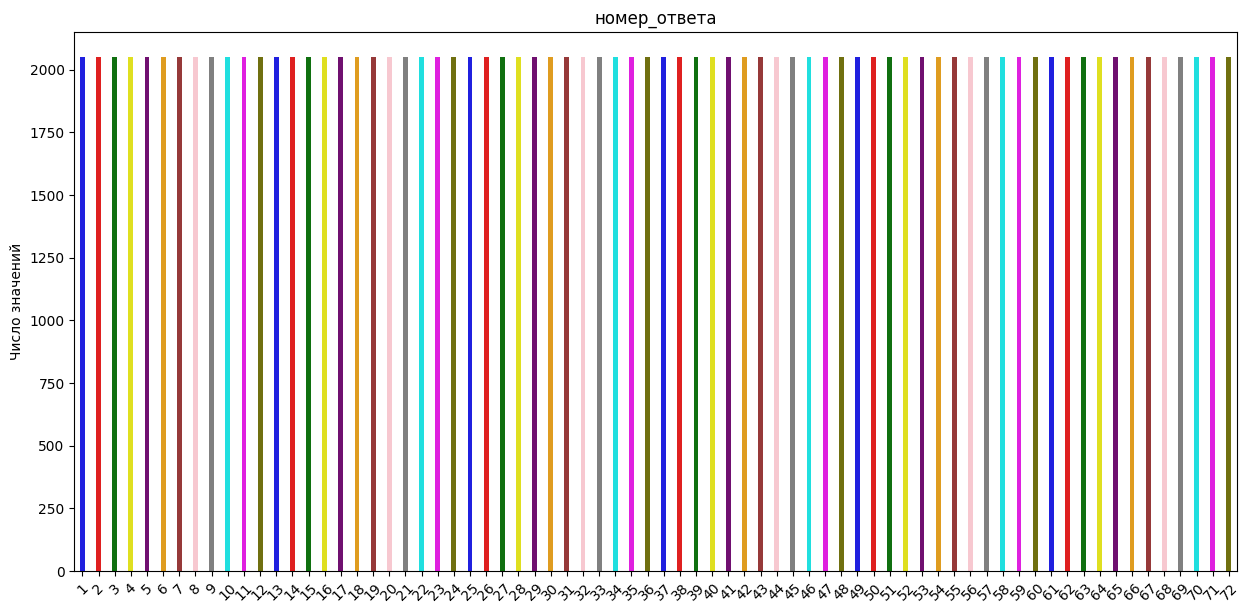


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №1: 'Стадия'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'IIIаI' -> кол-во: 73728
  1: 'IIIб' -> кол-во: 73728


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


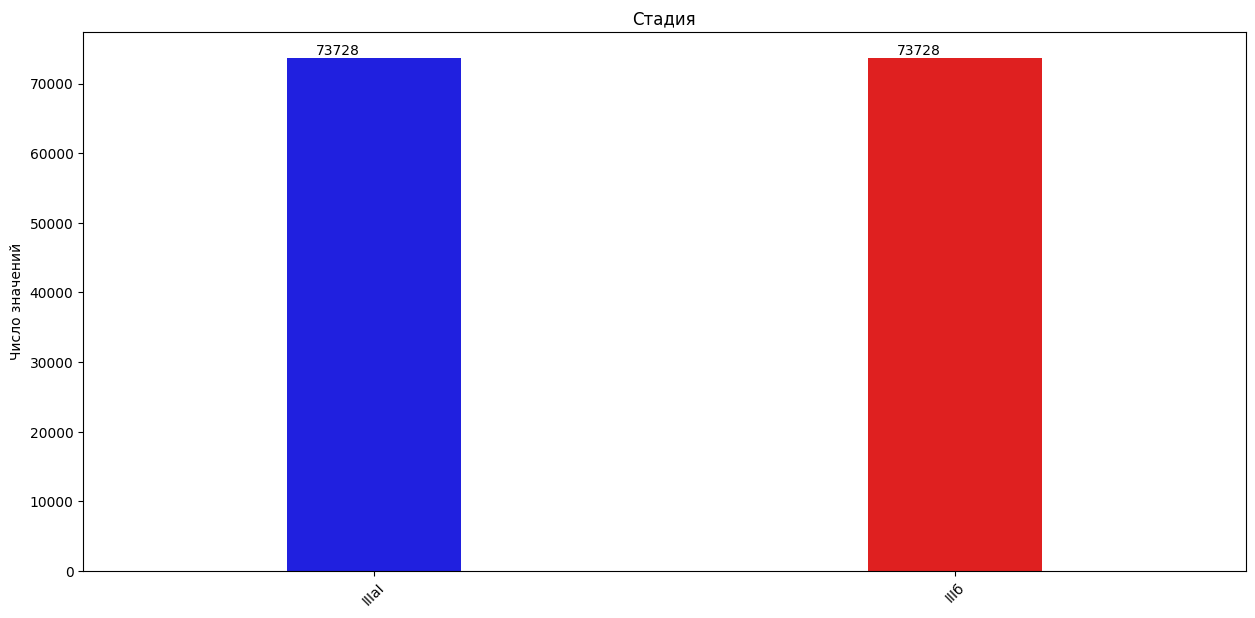


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №2: 'Гистология'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 3
  0: ' плоскоклеточный' -> кол-во: 49152
  1: ' неплоскоклеточный' -> кол-во: 49152
  2: ' мелкоклеточный' -> кол-во: 49152


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


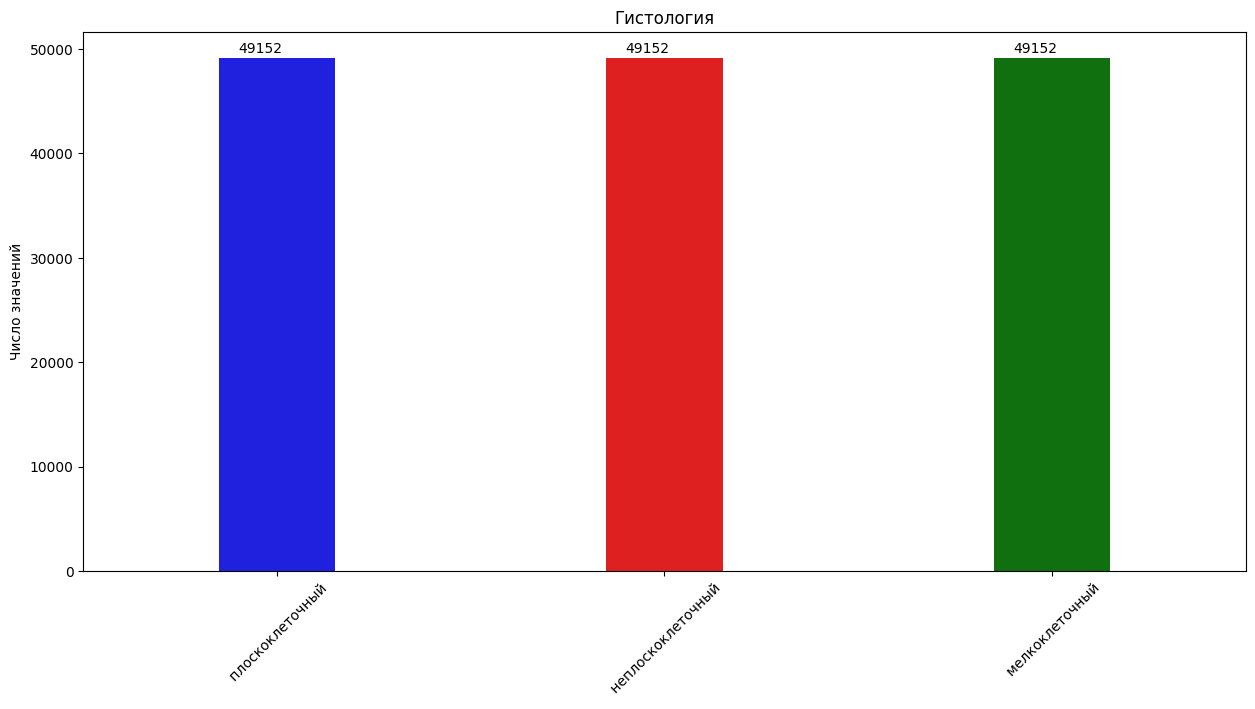


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №3: 'ECOG'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 3
  0: '  0-1' -> кол-во: 49152
  1: '2' -> кол-во: 49152
  2: ' 3+' -> кол-во: 49152


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


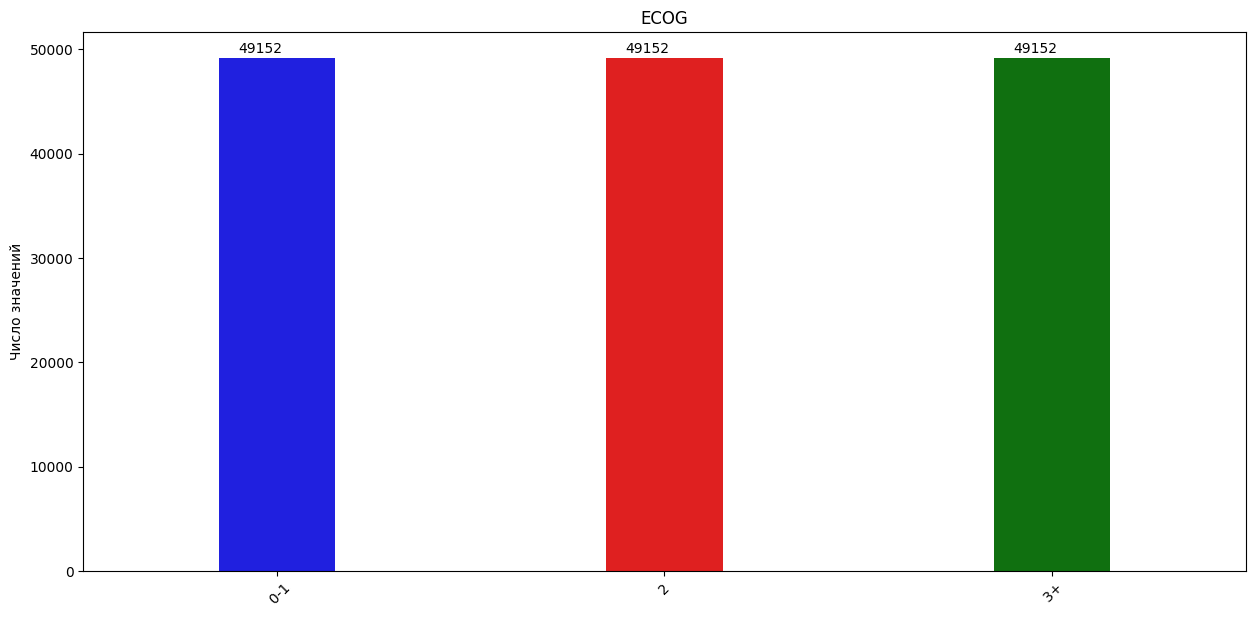


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №4: 'Возраст'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: ' До 70' -> кол-во: 73728
  1: ' >70' -> кол-во: 73728


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


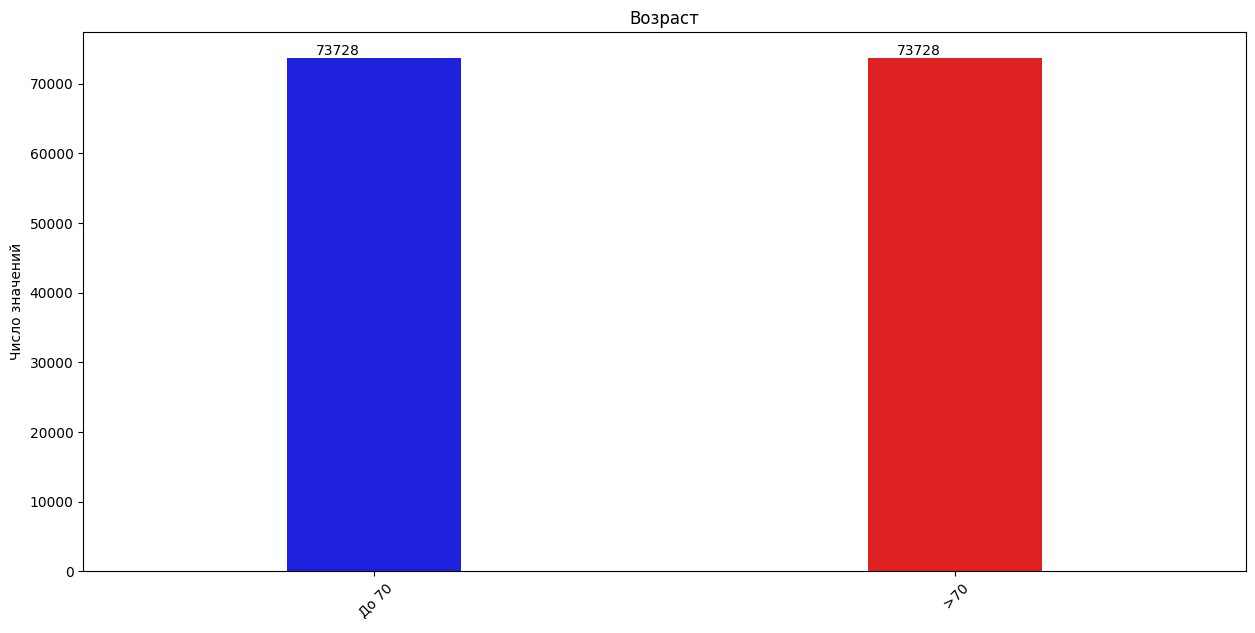


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №5: 'Пол'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'Мужской' -> кол-во: 73728
  1: 'Женский' -> кол-во: 73728


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


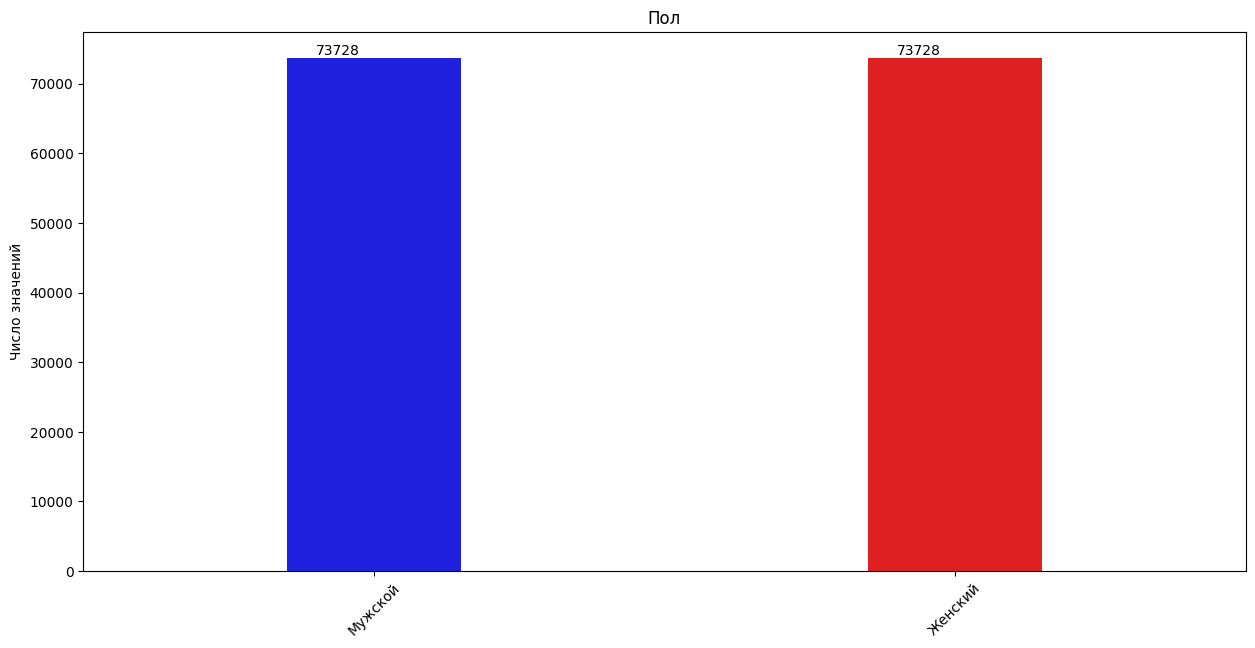


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №6: 'Молекулярный статус (только для неплоскоклеточного рака)'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 16
  0: ' нет мутаций' -> кол-во: 9216
  1: ' не исследовались' -> кол-во: 9216
  2: ' EGFR ex19' -> кол-во: 9216
  3: ' EGFR ex21' -> кол-во: 9216
  4: ' EGFR ex18' -> кол-во: 9216
  5: ' EGFR ex20' -> кол-во: 9216
  6: ' EGFR T790M' -> кол-во: 9216
  7: ' EGFR (G719X, L816Q, S768I)' -> кол-во: 9216
  8: ' ALK' -> кол-во: 9216
  9: ' ROS1' -> кол-во: 9216
  10: ' BRAF' -> кол-во: 9216
  11: ' RET' -> кол-во: 9216
  12: ' MET 14ex' -> кол-во: 9216
  13: ' HER2' -> кол-во: 9216
  14: ' KRAS G12C' -> кол-во: 9216
  15: ' NTRK' -> кол-во: 9216


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)
C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: UserWarning: 
The palette list has fewer values (12) than needed (16) and will cycle, which may produce an uninterpretable plot.
  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


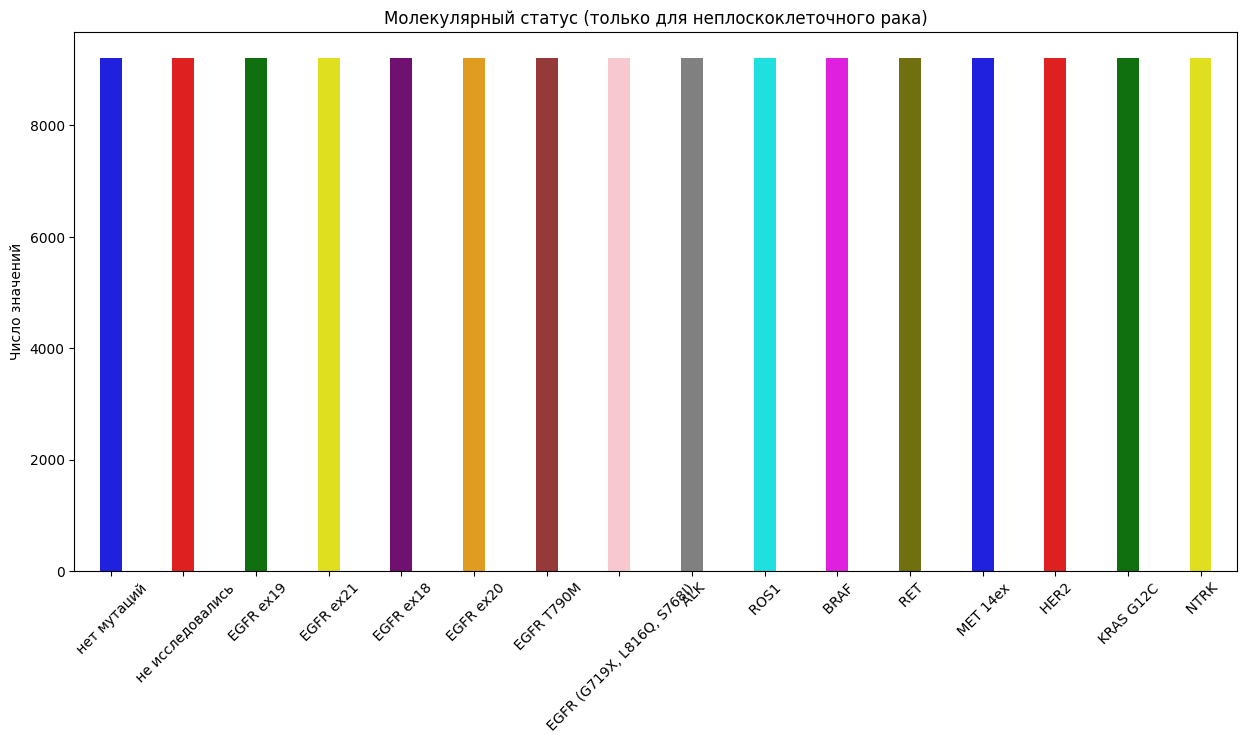


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №7: 'PD-L1 статус'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 4
  0: ' не исследовался' -> кол-во: 36864
  1: '0.01' -> кол-во: 36864
  2: ' 1–49 %' -> кол-во: 36864
  3: ' ≥50 %' -> кол-во: 36864


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


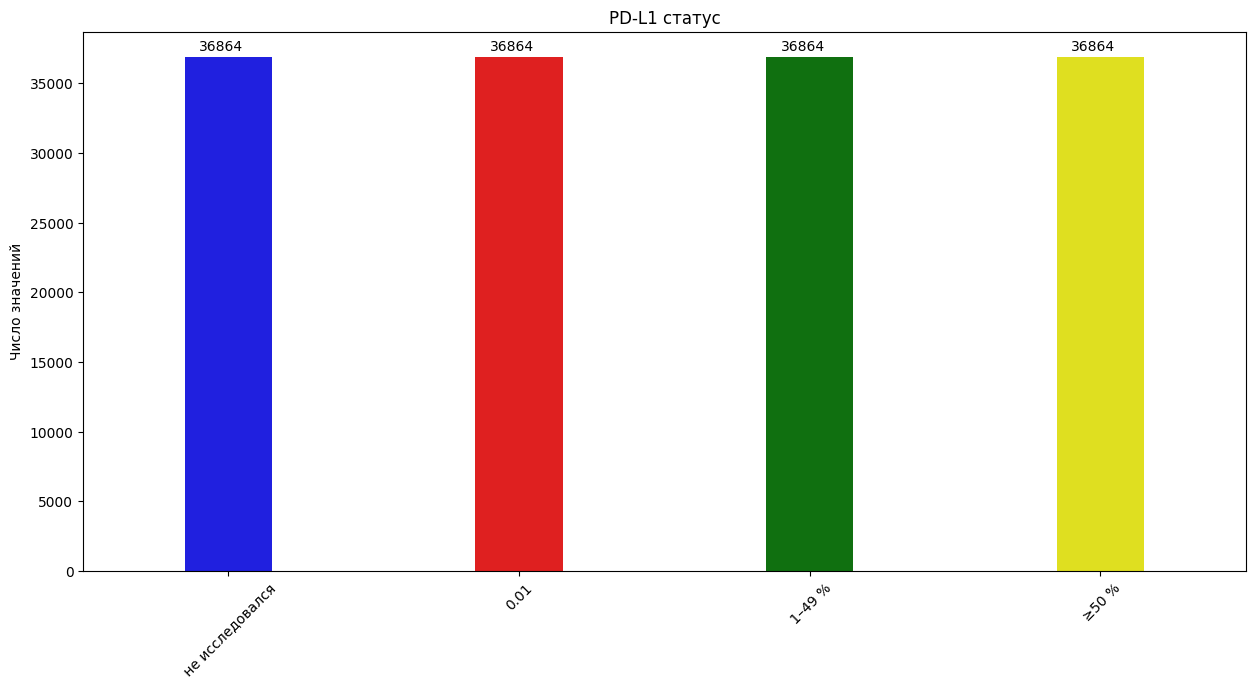


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №8: 'Статус курения'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 4
  0: ' В настоящее время' -> кол-во: 36864
  1: ' Курение в прошлом (бросил более 1 месяца до 1 года)' -> кол-во: 36864
  2: ' Курение в прошлом (бросил более 1 года)' -> кол-во: 36864
  3: ' Никогда не курил' -> кол-во: 36864


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)


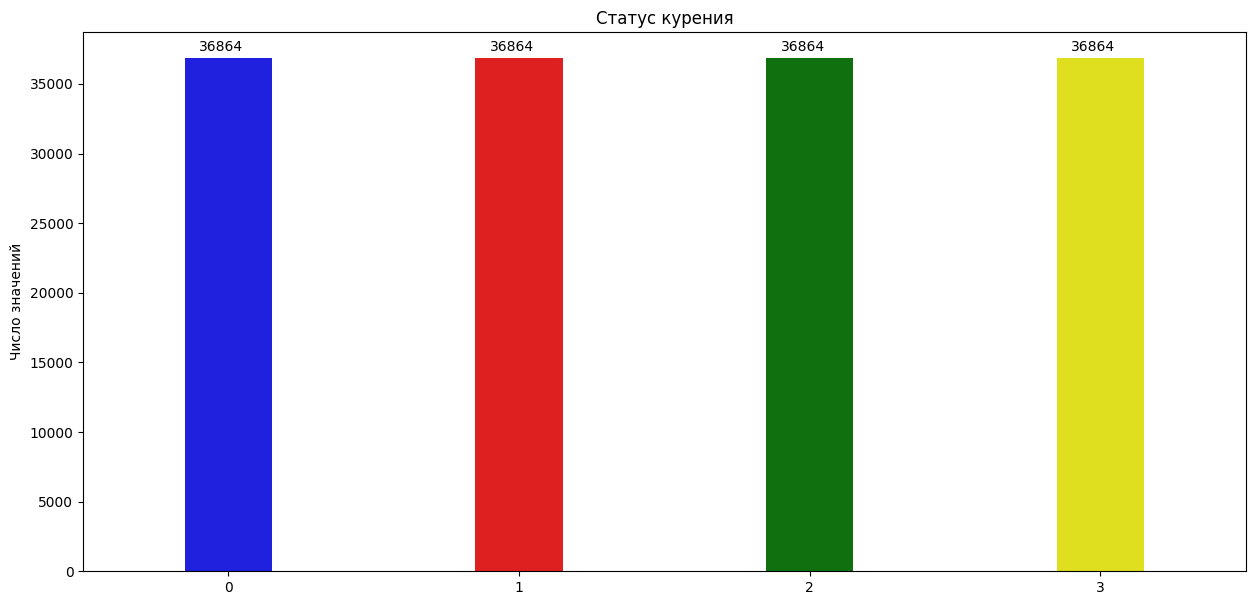


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №9: 'Относительные противопоказания к ЛТ'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: ' да' -> кол-во: 73728
  1: ' нет' -> кол-во: 73728


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


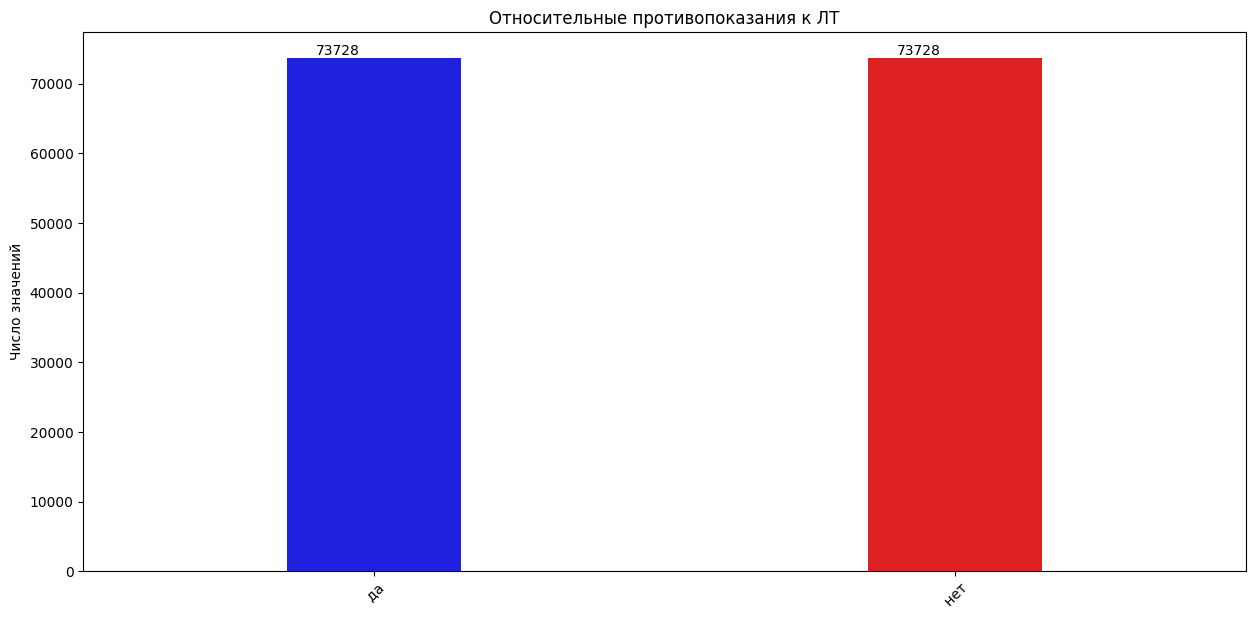


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №10: 'Предпочтение пациента по ответу на терапию'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: ' результативность лечения' -> кол-во: 73728
  1: ' сохранение качества жизни' -> кол-во: 73728


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


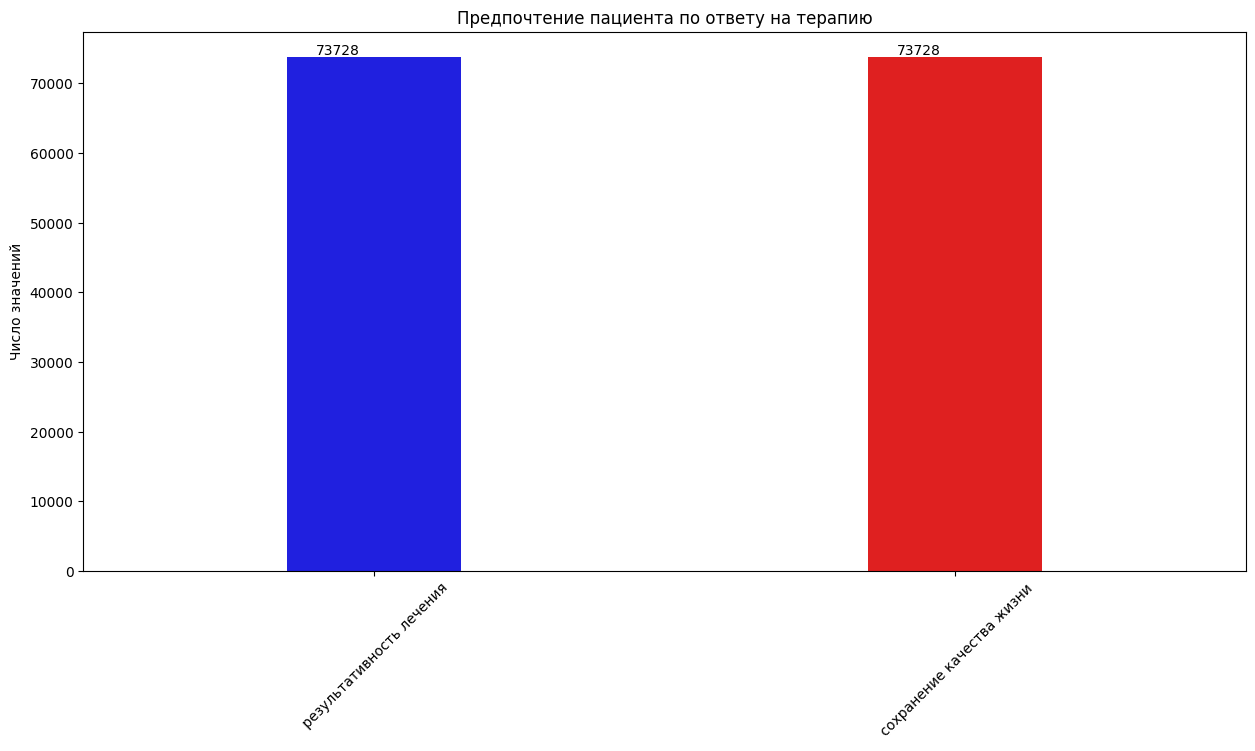


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №11: 'Ответ эксперта (Лактионов)'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 7
  0: 'переход на вариант лечения IV стадии' -> кол-во: 73728
  1: 'одномоментная ХЛТ' -> кол-во: 36864
  2: 'последовательная ХЛТ' -> кол-во: 20480
  3: 'Лучевая терапия' -> кол-во: 8192
  4: 'ПХТ' -> кол-во: 4096
  5: 'Симптоматическая терапия' -> кол-во: 2048
  6: 'Монохимиотерапия' -> кол-во: 2048


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)


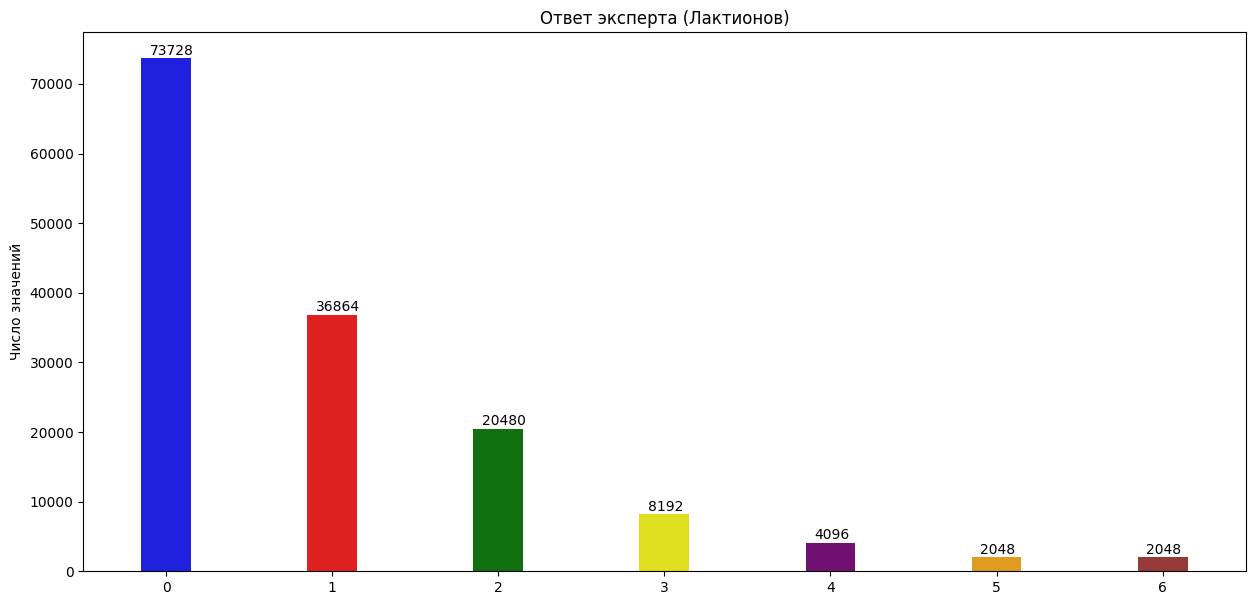


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №12: 'Вариант ХТ'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 8
  0: '0' -> кол-во: 83968
  1: 'паклитаксел+карбоплатин' -> кол-во: 20480
  2: 'этопозид+цисплатин' -> кол-во: 4096
  3: 'этопозид карбоплатин' -> кол-во: 22528
  4: 'Этопозид цисплатин' -> кол-во: 2048
  5: 'пеметрексед+цисплатин' -> кол-во: 8192
  6: 'пеметрексед' -> кол-во: 2048
  7: 'Этопозид монорежим' -> кол-во: 4096


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


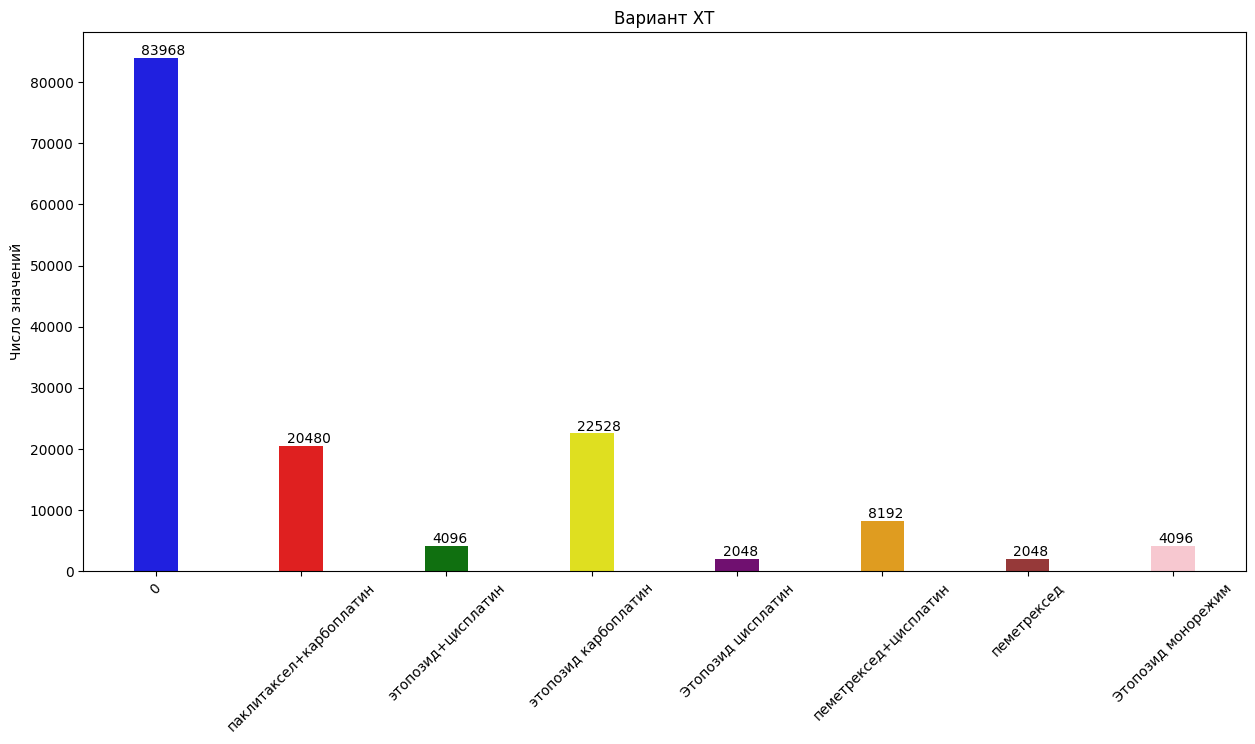


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №13: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 5
  0: '0' -> кол-во: 108544
  1: 'паклитаксел' -> кол-во: 12288
  2: 'пеметрексед' -> кол-во: 10240
  3: 'Этопозид монорежим' -> кол-во: 8192
  4: 'еженедельный паклитаксел' -> кол-во: 8192


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


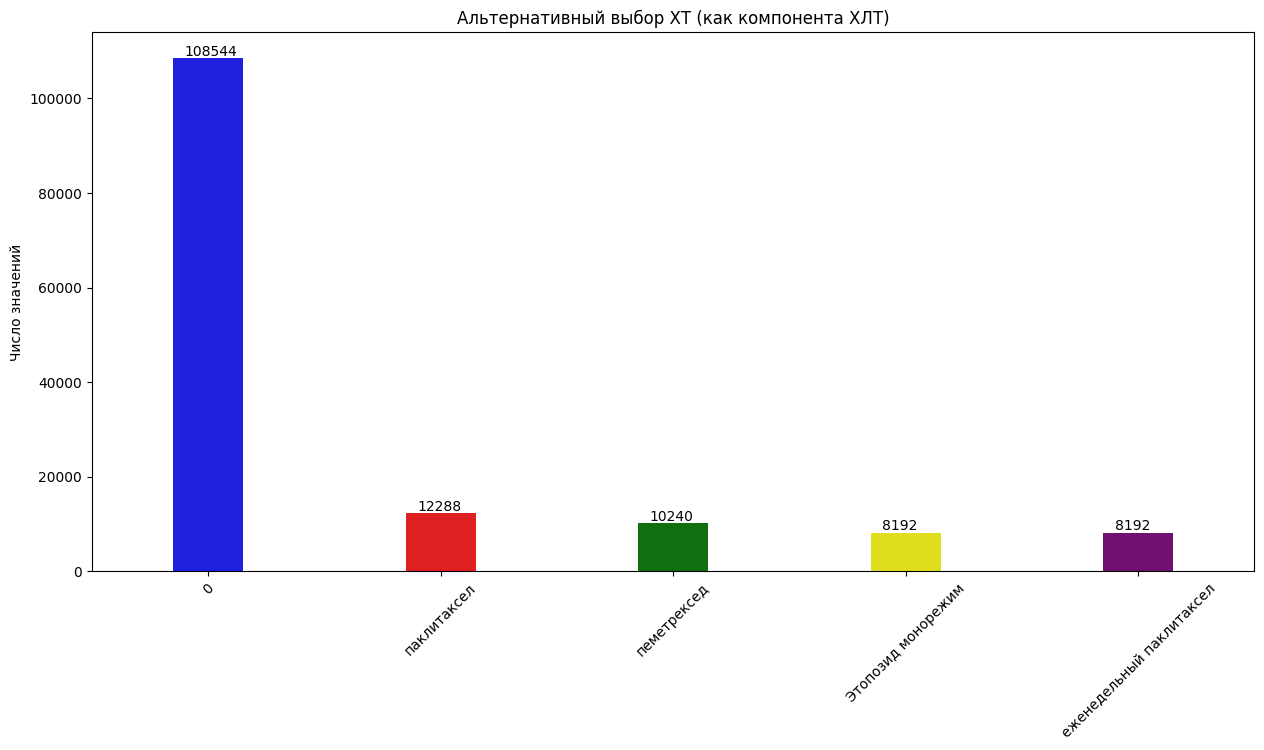


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №14: 'Поставьте галочку, если уверены на 100%'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'True' -> кол-во: 108544
  1: 'False' -> кол-во: 38912


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


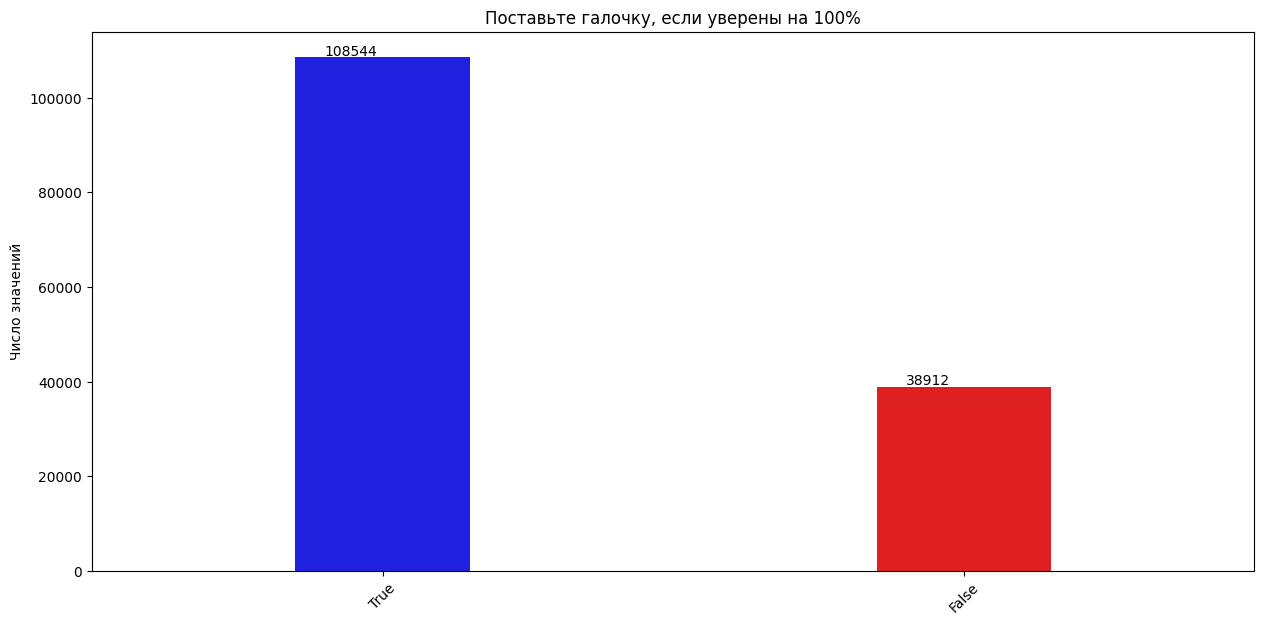


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №15: 'Если 75%'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'False' -> кол-во: 116736
  1: 'True' -> кол-во: 30720


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


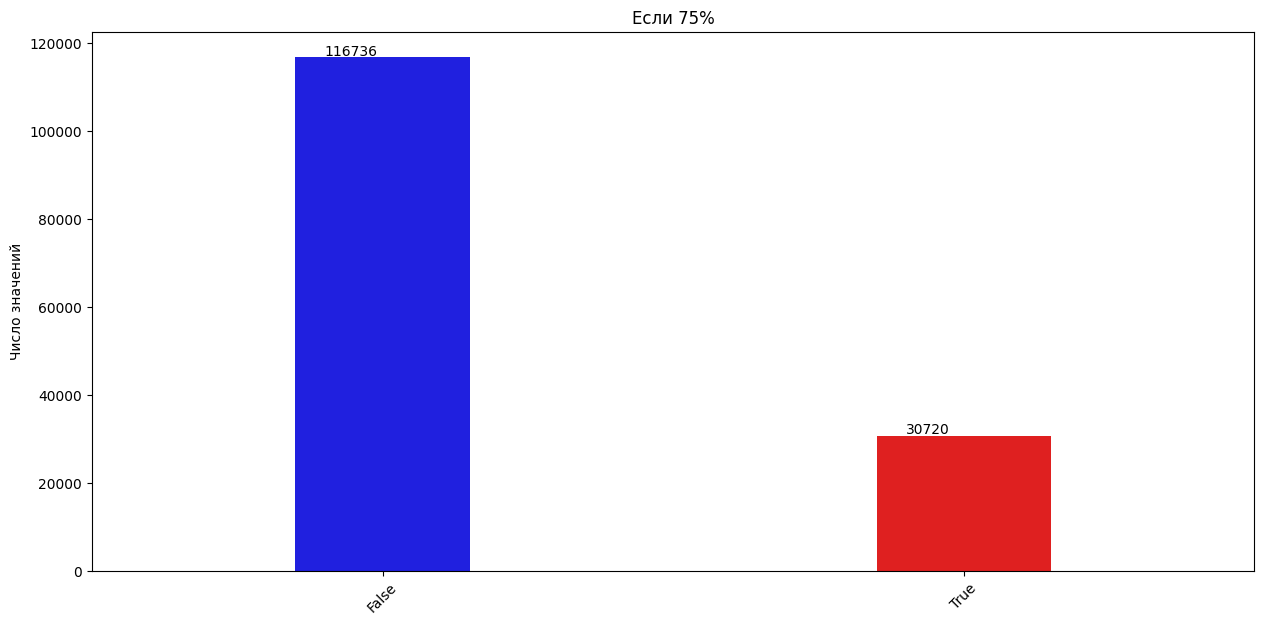

C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №16: 'Если 50%'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'False' -> кол-во: 139264
  1: 'True' -> кол-во: 8192


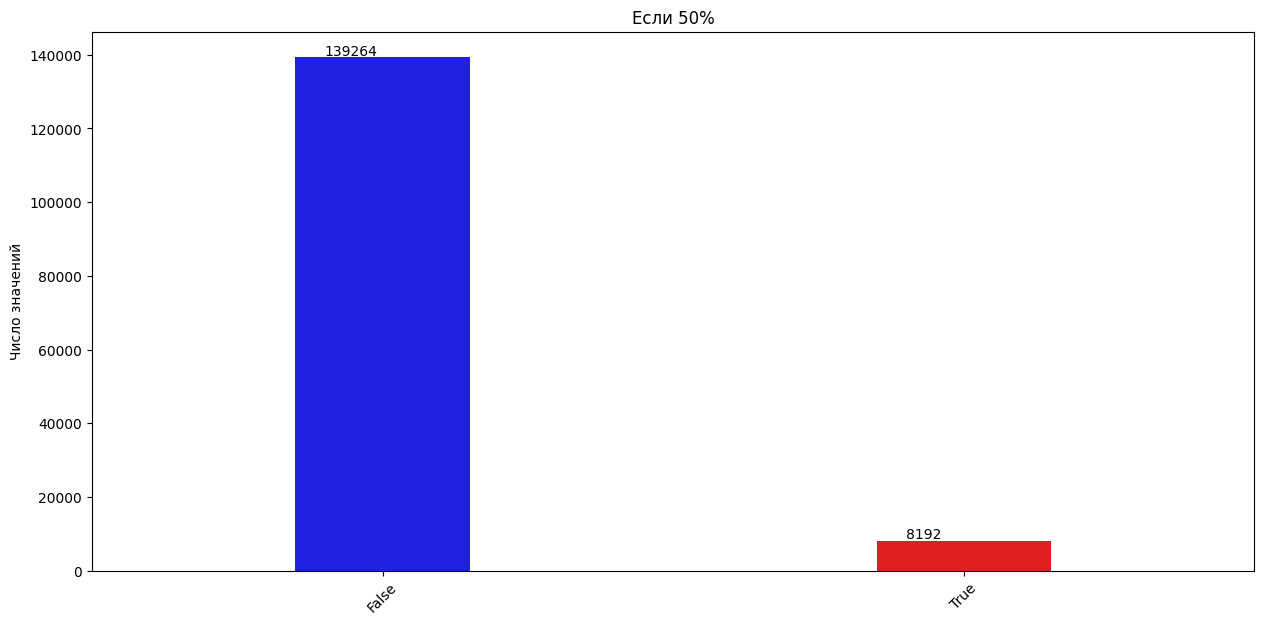


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №17: 'Альтернатива, если 50% - обязательно'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: '0' -> кол-во: 139264
  1: 'Вариант лечения IV стадии' -> кол-во: 8192


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


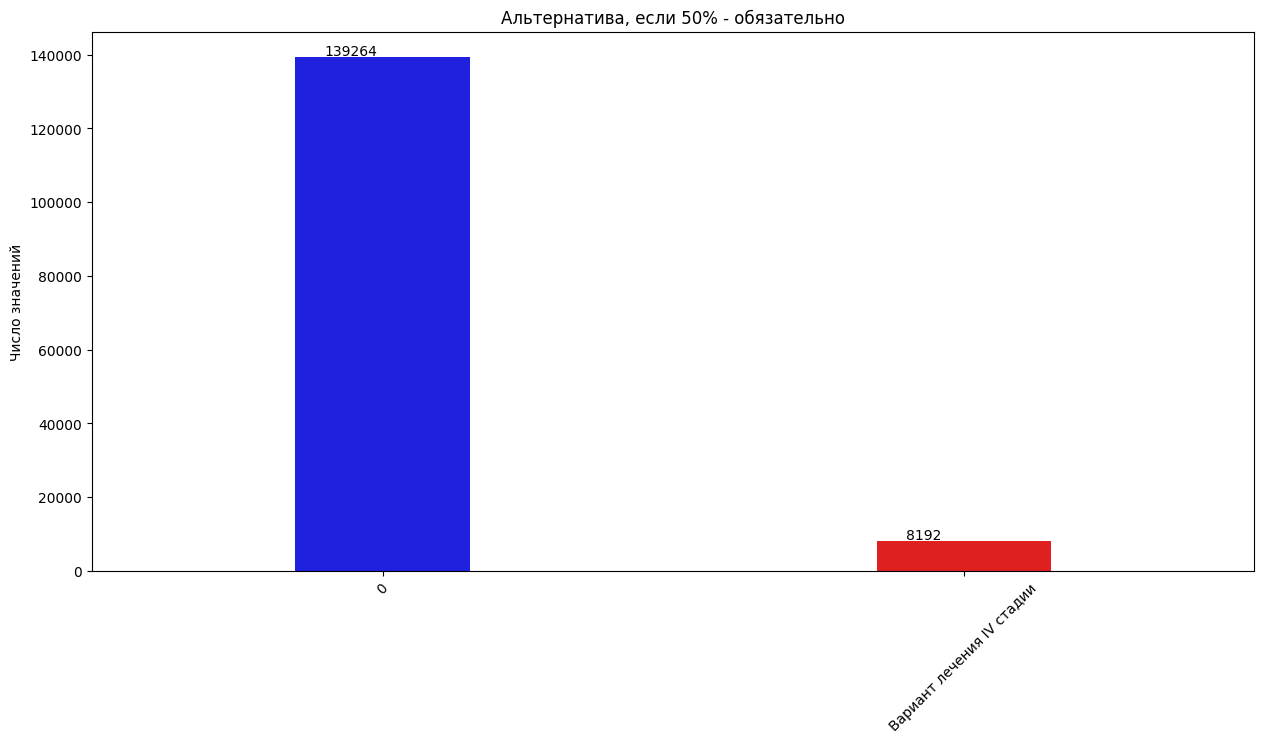


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №18: 'Комментарий'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: '0' -> кол-во: 139264
  1: 'Большая вероятность инкурабельности больного' -> кол-во: 8192


C:\Users\alexe\AppData\Local\Temp\ipykernel_3400\3997239512.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)


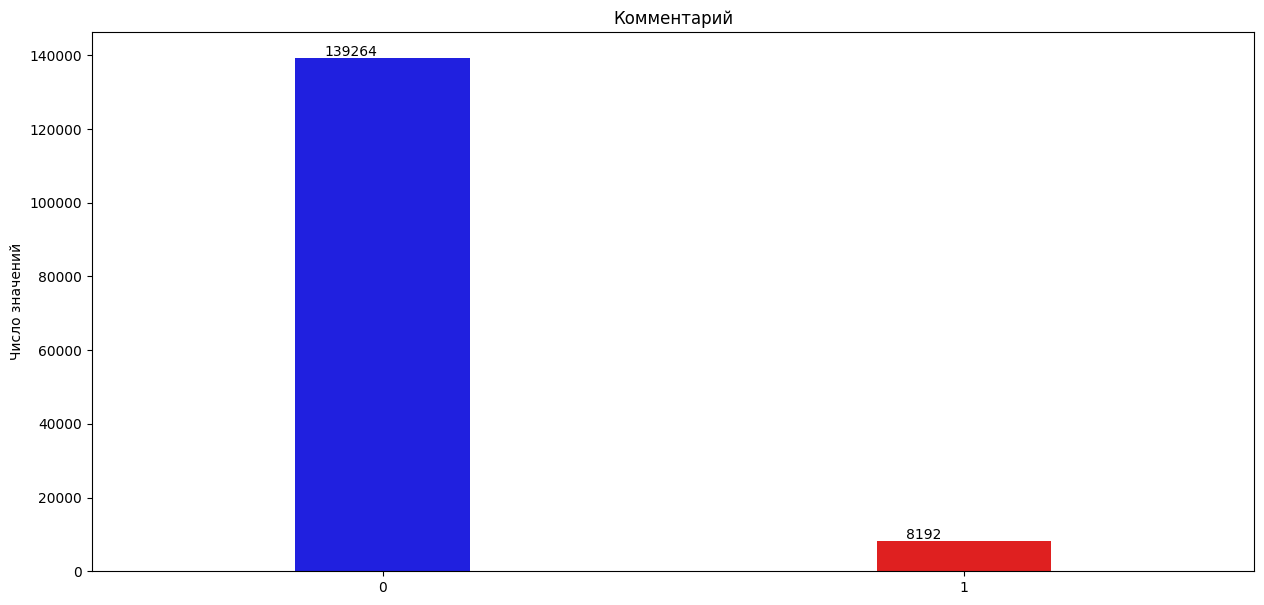

In [9]:
# Пробегаюсь по всем колонкам датафрейма и оцениваю балансировку
# i = 0
for col_name in df1_colnames:
  # print(f"i: {i}, col_name: '{col_name}'")
  # i += 1
  if 'id_ответа' == col_name:
    continue
  print_column_info(df1, col_name)

Вывод: первые 10 колонок датасета "Стадия" .. "Предпочтение пациента по ответу на терапию" идеально сбалансированы - число элементов каждой категории одинаковое.

## Датафрейм для обучения нейронной сети


In [10]:
# Создаем датафрейм, который будет использоваться для обучения нейронной сети
# alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# 00 - 'A' - 'номер_ответа' ===> можно исключить
# 01 - 'B1' - 'Стадия' - 2типа
# 02 - 'C1','C2','C3' - 'Гистология' - 3типа
# 03 - 'D1','D2','D3' - 'ECOG' - 3типа
# 04 - 'E1' - 'Возраст' - 2типа
# 05 - 'F1' - 'Пол' - 2типа
# 06 - 'G1','G2'...'G16' - 'Молекулярный статус (только для неплоскоклеточного рака)' - 16типов
# 07 - 'H1','H2','H3','H4' - 'PD-L1 статус' - 4типа
# 08 - 'I1','I2','I3','I4' - 'Статус курения' - 4типа
# 09 - 'J1' - 'Относительные противопоказания к ЛТ' - 2типа
# 10 - 'K1' - 'Предпочтение пациента по ответу на терапию' - 2типа
#~~~
# 11 - L1 - 'Ответ эксперта (Лактионов)'
# 12 - L1 - 'Вариант ХТ'
# 13 - L1 - 'Альтернативный выбор ХТ (как компонента ХЛТ)'
# 14 - L1 - 'Поставьте галочку, если уверены на 100%'
# 14 - L1 - 'Если 75%'
# 14 - L1 - 'Если 50%'
# 15 - L1 - 'Альтернатива, если 50% - обязательно'
# 16 - L1 - 'Комментарий'

dfxy1_cols = ['B1','C1','C2','C3','D1','D2','D3','E1','F1',
              'G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','G13','G14','G15','G16',
              'H1','H2','H3','H4','I1','I2','I3','I4','J1','K1','L1']
#~~~~~~~~~~~~~~~~~~~~~~~~
dfxy1 = pd.DataFrame(columns=dfxy1_cols, dtype=int)
print(f'размеры датафрейма dfxy1: {dfxy1.shape}')
print(f'  число строк: {dfxy1.shape[0]}')
print(f'  число колонок: {dfxy1.shape[1]}')

# dfxy1.info()

размеры датафрейма dfxy1: (0, 36)
  число строк: 0
  число колонок: 36


## 01 - 'B1' - 'Стадия' - 2типа

In [11]:
def print_unique_values(df, col_name):
  '''
  Функция отображение уникальных значений колонки

  Args:
    df - pandas.DataFrame
    col_name - column_name название колонки

  Returns:
    отображение иформации
  '''

  print(f"колонка: '{col_name}'")
  # строки с уникальными значениями unique_values
  unique_values = df1[col_name].unique().tolist()
  unique_count = len(unique_values)
  print(f'число уникальных значений: {unique_count}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  unique_values2 = list()
  for i in range(unique_count):
    u_item_str = str(unique_values[i])
    u_item_str2 = u_item_str.strip()
    unique_values2.append(u_item_str2)
  #~~~
  unique_values2.sort()

  #~~~~~~~~~~~~~~~~~~~~~~~~
  for i in range(unique_count):
    u_item_str2 = unique_values2[i]
    u_item_str3 = u_item_str2.lower()
    print(f"  {i}: '{u_item_str2}'; '{u_item_str3}'")

In [12]:
def check_categorization(df, col_name, cat_arr):
  '''
  Функция проверки категоризации

  Args:
    df - pandas.DataFrame
    col_name - column_name название колонки
    cat_arr - массив категоризованных значений

  Returns:
    отображение иформации
  '''

  print(f"колонка: '{col_name}'")
  # строки с уникальными значениями unique_values
  unique_values = df1[col_name].unique().tolist()
  unique_count = len(unique_values)
  print(f'число уникальных значений: {unique_count}')
  equal_items = 0
  for i in range(unique_count):
    u_item_str = str(unique_values[i])
    row_inx = 0
    for elem_val in df1[col_name]:
      elem_str = str(elem_val)
      if u_item_str == elem_str:
        print(f"  {i}: '{u_item_str}', category code: {cat_arr[row_inx]}, row index: {row_inx}")
        equal_items += 1
        break
      row_inx += 1
  print(f'  число элементов, по которым произведена проверка категориального кодирования: {equal_items}')

In [13]:
# 1->19: 'Стадия'
# трансформирую значения в категориальные и добавляю их в датафрейм
inx1 = 1
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Стадия'
число уникальных значений: 2
  0: 'IIIаI'; 'iiiаi'
  1: 'IIIб'; 'iiiб'


In [14]:
def getStageCode(str_val):
  '''
  Получение категориального значения `Стадия` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Стадия'
    число уникальных значений: 2
      0: ' IIIаI', 'iiiаi'
      1: ' IIIб', 'iiiб'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'iiiаi' == str2:
    retVal = 0
  elif 'iiiб' == str2:
    retVal = 1

  return retVal

In [15]:
# создаем numpy массив integer из нулей, число элементов равно числу строк нашего data frame
# cat - category
cat_arr1 = np.zeros(df1.shape[0], dtype=int)

#~~~~~~~~~~~~~~~~~~~~~~~~
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getStageCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Стадия'
число уникальных значений: 2
  0: 'IIIаI', category code: 0, row index: 0
  1: 'IIIб', category code: 1, row index: 1
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [16]:
# добавляем данные в датафрейм
# 01 - 'B1' - 'Стадия' - 2типа
dfxy1 = dfxy1.assign(B1=cat_arr1)
# dfxy1.head(3)
# dfxy1.tail(3)

## 02 - 'C1','C2','C3' - 'Гистология' - 3типа

In [17]:
# 2->19: 'Гистология'
inx1 = 2
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Гистология'
число уникальных значений: 3
  0: 'мелкоклеточный'; 'мелкоклеточный'
  1: 'неплоскоклеточный'; 'неплоскоклеточный'
  2: 'плоскоклеточный'; 'плоскоклеточный'


In [18]:
def getHistologyCode(str_val):
  '''
  Получение категориального значения `Гистология` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Гистология'
    число уникальных значений: 3
      0: ' плоскоклеточный'; 'плоскоклеточный'
      1: ' неплоскоклеточный'; 'неплоскоклеточный'
      2: ' мелкоклеточный'; 'мелкоклеточный'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'плоскоклеточный' == str2:
    retVal = 0
  elif 'неплоскоклеточный' == str2:
    retVal = 1
  elif 'мелкоклеточный' == str2:
    retVal = 2

  return retVal

In [19]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getHistologyCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Гистология'
число уникальных значений: 3
  0: ' плоскоклеточный', category code: 0, row index: 0
  1: ' неплоскоклеточный', category code: 1, row index: 2
  2: ' мелкоклеточный', category code: 2, row index: 4
  число элементов, по которым произведена проверка категориального кодирования: 3
число строк, которые не прошли категоризацию: 0


In [20]:
#~ преобразование массива в формат one-hot-encoding (3-класса)
cat_arr2 = utils.to_categorical(cat_arr1, 3)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 02 - 'C1','C2','C3' - 'Гистология' - 3типа
dfxy1 = dfxy1.assign(C1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(C2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(C3=cat_arr2_i[:, 2])

del cat_arr2
del cat_arr2_i

## 03 - 'D1','D2','D3' - 'ECOG' - 3типа

In [21]:
# 3->19: 'ECOG'
inx1 = 3
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'ECOG'
число уникальных значений: 3
  0: '0-1'; '0-1'
  1: '2'; '2'
  2: '3+'; '3+'


In [22]:
def getEcogCode(str_val):
  '''
  Получение категориального значения `ECOG` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'ECOG'
    число уникальных значений: 3
      0: '  0-1'; '0-1'
      1: '2'; '2'
      2: ' 3+'; '3+'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if '0-1' == str2:
    retVal = 0
  elif '2' == str2:
    retVal = 1
  elif '3+' == str2:
    retVal = 2

  return retVal

In [23]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getEcogCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'ECOG'
число уникальных значений: 3
  0: '  0-1', category code: 0, row index: 0
  1: '2', category code: 1, row index: 12
  2: ' 3+', category code: 2, row index: 24
  число элементов, по которым произведена проверка категориального кодирования: 3
число строк, которые не прошли категоризацию: 0


In [24]:
#~ преобразование массива в формат one-hot-encoding (3-класса)
cat_arr2 = utils.to_categorical(cat_arr1, 3)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 03 - 'D1','D2','D3' - 'ECOG' - 3типа
dfxy1 = dfxy1.assign(D1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(D2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(D3=cat_arr2_i[:, 2])

del cat_arr2
del cat_arr2_i

## 04 - 'E1' - 'Возраст' - 2типа

In [25]:
# 4->19: 'Возраст'
inx1 = 4
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Возраст'
число уникальных значений: 2
  0: '>70'; '>70'
  1: 'До 70'; 'до 70'


In [26]:
def getAgeCode(str_val):
  '''
  Получение категориального значения `Возраст` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Возраст'
    число уникальных значений: 2
      0: ' До 70'; 'до 70'
      1: ' >70'; '>70'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'до 70' == str2:
    retVal = 0
  elif '>70' == str2:
    retVal = 1

  return retVal

In [27]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getAgeCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Возраст'
число уникальных значений: 2
  0: ' До 70', category code: 0, row index: 0
  1: ' >70', category code: 1, row index: 36
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [28]:
# добавляем данные в датафрейм
# 04 - 'E1' - 'Возраст' - 2типа
dfxy1 = dfxy1.assign(E1=cat_arr1)

## 05 - 'F1' - 'Пол' - 2типа

In [29]:
# 5->19: 'Пол'
inx1 = 5
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Пол'
число уникальных значений: 2
  0: 'Женский'; 'женский'
  1: 'Мужской'; 'мужской'


In [30]:
def getGenderCode(str_val):
  '''
  Получение категориального значения `Пол` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Пол'
    число уникальных значений: 2
      0: 'Мужской'; 'мужской'
      1: 'Женский'; 'женский'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'мужской' == str2:
    retVal = 0
  elif 'женский' == str2:
    retVal = 1

  return retVal

In [31]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getGenderCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Пол'
число уникальных значений: 2
  0: 'Мужской', category code: 0, row index: 0
  1: 'Женский', category code: 1, row index: 72
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [32]:
# добавляем данные в датафрейм
# 05 - 'F1' - 'Пол' - 2типа
dfxy1 = dfxy1.assign(F1=cat_arr1)

## 06 - 'G1','G2'...'G16' - 'Молекулярный статус (только для неплоскоклеточного рака)' - 16типов


In [33]:
# 6->19: 'Молекулярный статус (только для неплоскоклеточного рака)'
inx1 = 6
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Молекулярный статус (только для неплоскоклеточного рака)'
число уникальных значений: 16
  0: 'ALK'; 'alk'
  1: 'BRAF'; 'braf'
  2: 'EGFR (G719X, L816Q, S768I)'; 'egfr (g719x, l816q, s768i)'
  3: 'EGFR T790M'; 'egfr t790m'
  4: 'EGFR ex18'; 'egfr ex18'
  5: 'EGFR ex19'; 'egfr ex19'
  6: 'EGFR ex20'; 'egfr ex20'
  7: 'EGFR ex21'; 'egfr ex21'
  8: 'HER2'; 'her2'
  9: 'KRAS G12C'; 'kras g12c'
  10: 'MET 14ex'; 'met 14ex'
  11: 'NTRK'; 'ntrk'
  12: 'RET'; 'ret'
  13: 'ROS1'; 'ros1'
  14: 'не исследовались'; 'не исследовались'
  15: 'нет мутаций'; 'нет мутаций'


In [34]:
def getMolecularStatusCode(str_val):
  '''
  Получение категориального значения `Молекулярный статус (только для неплоскоклеточного рака)` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Молекулярный статус (только для неплоскоклеточного рака)'
    число уникальных значений: 16
      0: 'не исследовались'; 'не исследовались'
      1: 'нет мутаций'; 'нет мутаций'
      2: 'ALK'; 'alk'
      3: 'BRAF'; 'braf'
      4: 'EGFR (G719X, L816Q, S768I)'; 'egfr (g719x, l816q, s768i)'
      5: 'EGFR T790M'; 'egfr t790m'
      6: 'EGFR ex18'; 'egfr ex18'
      7: 'EGFR ex19'; 'egfr ex19'
      8: 'EGFR ex20'; 'egfr ex20'
      9: 'EGFR ex21'; 'egfr ex21'
      10: 'HER2'; 'her2'
      11: 'KRAS G12C'; 'kras g12c'
      12: 'MET 14ex'; 'met 14ex'
      13: 'NTRK'; 'ntrk'
      14: 'RET'; 'ret'
      15: 'ROS1'; 'ros1'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'не исследовались' == str2:
    retVal = 0
  elif 'нет мутаций' == str2:
    retVal = 1
  elif 'alk' == str2:
    retVal = 2
  elif 'braf' == str2:
    retVal = 3
  elif 'egfr (g719x, l816q, s768i)' == str2:
    retVal = 4
  elif 'egfr t790m' == str2:
    retVal = 5
  elif 'egfr ex18' == str2:
    retVal = 6
  elif 'egfr ex19' == str2:
    retVal = 7
  elif 'egfr ex20' == str2:
    retVal = 8
  elif 'egfr ex21' == str2:
    retVal = 9
  elif 'her2' == str2:
    retVal = 10
  elif 'kras g12c' == str2:
    retVal = 11
  elif 'met 14ex' == str2:
    retVal = 12
  elif 'ntrk' == str2:
    retVal = 13
  elif 'ret' == str2:
    retVal = 14
  elif 'ros1' == str2:
    retVal = 15

  return retVal

In [35]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getMolecularStatusCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Молекулярный статус (только для неплоскоклеточного рака)'
число уникальных значений: 16
  0: ' нет мутаций', category code: 1, row index: 0
  1: ' не исследовались', category code: 0, row index: 1152
  2: ' EGFR ex19', category code: 7, row index: 2304
  3: ' EGFR ex21', category code: 9, row index: 3456
  4: ' EGFR ex18', category code: 6, row index: 4608
  5: ' EGFR ex20', category code: 8, row index: 5760
  6: ' EGFR T790M', category code: 5, row index: 6912
  7: ' EGFR (G719X, L816Q, S768I)', category code: 4, row index: 8064
  8: ' ALK', category code: 2, row index: 9216
  9: ' ROS1', category code: 15, row index: 10368
  10: ' BRAF', category code: 3, row index: 11520
  11: ' RET', category code: 14, row index: 12672
  12: ' MET 14ex', category code: 12, row index: 13824
  13: ' HER2', category code: 10, row index: 14976
  14: ' KRAS G12C', category code: 11, row index: 16128
  15: ' NTRK', category code: 13, row index: 17280
  число элементов, по которым произведена пр

In [36]:
#~ преобразование массива в формат one-hot-encoding (16-классов)
cat_arr2 = utils.to_categorical(cat_arr1, 16)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 06 - 'G1','G2'...'G16' - 'Молекулярный статус (только для неплоскоклеточного рака)' - 16типов
dfxy1 = dfxy1.assign(G1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(G2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(G3=cat_arr2_i[:, 2])
dfxy1 = dfxy1.assign(G4=cat_arr2_i[:, 3])
dfxy1 = dfxy1.assign(G5=cat_arr2_i[:, 4])
dfxy1 = dfxy1.assign(G6=cat_arr2_i[:, 5])
dfxy1 = dfxy1.assign(G7=cat_arr2_i[:, 6])
dfxy1 = dfxy1.assign(G8=cat_arr2_i[:, 7])
dfxy1 = dfxy1.assign(G9=cat_arr2_i[:, 8])
dfxy1 = dfxy1.assign(G10=cat_arr2_i[:, 9])
dfxy1 = dfxy1.assign(G11=cat_arr2_i[:, 10])
dfxy1 = dfxy1.assign(G12=cat_arr2_i[:, 11])
dfxy1 = dfxy1.assign(G13=cat_arr2_i[:, 12])
dfxy1 = dfxy1.assign(G14=cat_arr2_i[:, 13])
dfxy1 = dfxy1.assign(G15=cat_arr2_i[:, 14])
dfxy1 = dfxy1.assign(G16=cat_arr2_i[:, 15])

del cat_arr2
del cat_arr2_i

In [37]:
def print_cell_value(df, row_idx, col_name):
  '''
  Функция отображает значение ячейки

  Args:
    df - pandas.DataFrame
    row_idx - индекс строки
    col_name - название колонки в dfxy
  Returns:
    отображение значения ячейки
  '''
  col_idx = df.columns.get_loc(col_name)
  # print(f'col_name: `{col_name}`, col_idx: `{col_idx}`')
  print(f'строка: {row_idx}, колонка: {col_idx}, значение: {df.iloc[row_idx, col_idx]}')

In [38]:
# 06 - 'G1','G2'...'G16' - 'Молекулярный статус (только для неплоскоклеточного рака)' - 16типов
print_cell_value(df1, 0, 'Молекулярный статус (только для неплоскоклеточного рака)')
print_cell_value(dfxy1, 0, 'G1')
print_cell_value(dfxy1, 0, 'G2')
print_cell_value(dfxy1, 0, 'G3')
print_cell_value(dfxy1, 0, 'G4')
print_cell_value(dfxy1, 0, 'G5')
print_cell_value(dfxy1, 0, 'G6')
print_cell_value(dfxy1, 0, 'G7')
print_cell_value(dfxy1, 0, 'G8')
print_cell_value(dfxy1, 0, 'G9')
print_cell_value(dfxy1, 0, 'G10')
print_cell_value(dfxy1, 0, 'G11')
print_cell_value(dfxy1, 0, 'G12')
print_cell_value(dfxy1, 0, 'G13')
print_cell_value(dfxy1, 0, 'G14')
print_cell_value(dfxy1, 0, 'G15')
print_cell_value(dfxy1, 0, 'G16')

строка: 0, колонка: 6, значение:  нет мутаций
строка: 0, колонка: 9, значение: 0
строка: 0, колонка: 10, значение: 1
строка: 0, колонка: 11, значение: 0
строка: 0, колонка: 12, значение: 0
строка: 0, колонка: 13, значение: 0
строка: 0, колонка: 14, значение: 0
строка: 0, колонка: 15, значение: 0
строка: 0, колонка: 16, значение: 0
строка: 0, колонка: 17, значение: 0
строка: 0, колонка: 18, значение: 0
строка: 0, колонка: 19, значение: 0
строка: 0, колонка: 20, значение: 0
строка: 0, колонка: 21, значение: 0
строка: 0, колонка: 22, значение: 0
строка: 0, колонка: 23, значение: 0
строка: 0, колонка: 24, значение: 0


## 07 - 'H1','H2','H3','H4' - 'PD-L1 статус' - 4типа

In [39]:
# 7->19: 'PD-L1 статус'
inx1 = 7
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'PD-L1 статус'
число уникальных значений: 4
  0: '0.01'; '0.01'
  1: '1–49 %'; '1–49 %'
  2: 'не исследовался'; 'не исследовался'
  3: '≥50 %'; '≥50 %'


In [40]:
def getPD_L1StatusCode(str_val):
  '''
  Получение категориального значения `PD-L1 статус` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'PD-L1 статус'
    число уникальных значений: 4
      0: 'не исследовался' ===> 'неисследовался'
      1: '0.01','1%'       ===> '0.01', '1'
      2: '1–49 %'          ===> '1–49'
      3: '≥50 %'           ===> '≥50'
  '''

  str2 = str_val.lower().strip()
  str3 = str2.replace('%', '').replace(' ', '')
  str4 = str3.strip()

  retVal = -1
  if 'неисследовался' == str4:
    retVal = 0
  elif '0.01' == str4:
    retVal = 1
  elif '1' == str4:
    retVal = 1
  elif '1–49' == str4:
    retVal = 2
  elif '≥50' == str4:
    retVal = 3

  return retVal

In [41]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getPD_L1StatusCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'PD-L1 статус'
число уникальных значений: 4
  0: ' не исследовался', category code: 0, row index: 0
  1: '0.01', category code: 1, row index: 18432
  2: ' 1–49 %', category code: 2, row index: 36864
  3: ' ≥50 %', category code: 3, row index: 55296
  число элементов, по которым произведена проверка категориального кодирования: 4
число строк, которые не прошли категоризацию: 0


In [42]:
#~ преобразование массива в формат one-hot-encoding (4-класса)
cat_arr2 = utils.to_categorical(cat_arr1, 4)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 07 - 'H1','H2','H3','H4' - 'PD-L1 статус' - 4типа
dfxy1 = dfxy1.assign(H1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(H2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(H3=cat_arr2_i[:, 2])
dfxy1 = dfxy1.assign(H4=cat_arr2_i[:, 3])

del cat_arr2
del cat_arr2_i

In [43]:
# 07 - 'H1','H2','H3','H4' - 'PD-L1 статус' - 4типа
print_cell_value(df1, 0, 'PD-L1 статус')
print_cell_value(dfxy1, 0, 'H1')
print_cell_value(dfxy1, 0, 'H2')
print_cell_value(dfxy1, 0, 'H3')
print_cell_value(dfxy1, 0, 'H4')

строка: 0, колонка: 7, значение:  не исследовался
строка: 0, колонка: 25, значение: 1
строка: 0, колонка: 26, значение: 0
строка: 0, колонка: 27, значение: 0
строка: 0, колонка: 28, значение: 0


## 08 - 'I1','I2','I3','I4' - 'Статус курения' - 4типа

In [44]:
# 8->19: 'Статус курения'
inx1 = 8
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Статус курения'
число уникальных значений: 4
  0: 'В настоящее время'; 'в настоящее время'
  1: 'Курение в прошлом (бросил более 1 года)'; 'курение в прошлом (бросил более 1 года)'
  2: 'Курение в прошлом (бросил более 1 месяца до 1 года)'; 'курение в прошлом (бросил более 1 месяца до 1 года)'
  3: 'Никогда не курил'; 'никогда не курил'


In [45]:
def getSmokingStatusCode(str_val):
  '''
  Получение категориального значения `Статус курения` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Статус курения'
    число уникальных значений: 4
      0: ' В настоящее время'; 'в настоящее время'
      1: ' Курение в прошлом (бросил более 1 месяца до 1 года)'; 'курение в прошлом (бросил более 1 месяца до 1 года)'
      2: ' Курение в прошлом (бросил более 1 года)'; 'курение в прошлом (бросил более 1 года)'
      3: ' Никогда не курил'; 'никогда не курил'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'в настоящее время' == str2:
    retVal = 0
  elif 'курение в прошлом (бросил более 1 месяца до 1 года)' == str2:
    retVal = 1
  elif 'курение в прошлом (бросил более 1 года)' == str2:
    retVal = 2
  elif 'никогда не курил' == str2:
    retVal = 3

  return retVal

In [46]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getSmokingStatusCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Статус курения'
число уникальных значений: 4
  0: ' В настоящее время', category code: 0, row index: 0
  1: ' Курение в прошлом (бросил более 1 месяца до 1 года)', category code: 1, row index: 144
  2: ' Курение в прошлом (бросил более 1 года)', category code: 2, row index: 288
  3: ' Никогда не курил', category code: 3, row index: 432
  число элементов, по которым произведена проверка категориального кодирования: 4
число строк, которые не прошли категоризацию: 0


In [47]:
#~ преобразование массива в формат one-hot-encoding (4-класса)
cat_arr2 = utils.to_categorical(cat_arr1, 4)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 08 - 'I1','I2','I3','I4' - 'Статус курения' - 4типа
dfxy1 = dfxy1.assign(I1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(I2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(I3=cat_arr2_i[:, 2])
dfxy1 = dfxy1.assign(I4=cat_arr2_i[:, 3])

del cat_arr2
del cat_arr2_i

## 09 - 'J1' - 'Относительные противопоказания к ЛТ' - 2типа

In [48]:
# 9->19: 'Относительные противопоказания к ЛТ'
inx1 = 9
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Относительные противопоказания к ЛТ'
число уникальных значений: 2
  0: 'да'; 'да'
  1: 'нет'; 'нет'


In [49]:
def getNoYesCodeStr(str_val):
  '''
  Получение категориального значения `нет-да` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    число уникальных значений: 2
    0: ' нет', 'нет'
    1: ' да', 'да'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'нет' == str2:
    retVal = 0
  elif 'да' == str2:
    retVal = 1

  return retVal  

In [50]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getNoYesCodeStr(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Относительные противопоказания к ЛТ'
число уникальных значений: 2
  0: ' да', category code: 1, row index: 0
  1: ' нет', category code: 0, row index: 6
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [51]:
# 09 - 'J1' - 'Относительные противопоказания к ЛТ' - 2типа
dfxy1 = dfxy1.assign(J1=cat_arr1)

## 10 - 'K1' - 'Предпочтение пациента по ответу на терапию' - 2типа

In [52]:
# 10->19: 'Предпочтение пациента по ответу на терапию'
inx1 = 10
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Предпочтение пациента по ответу на терапию'
число уникальных значений: 2
  0: 'результативность лечения'; 'результативность лечения'
  1: 'сохранение качества жизни'; 'сохранение качества жизни'


In [53]:
def getPatientPreferenceCode(str_val):
  '''
  Получение категориального значения `Предпочтение пациента по ответу на терапию` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Предпочтение пациента по ответу на терапию'
    число уникальных значений: 2
      0: 'результативность лечения'; 'результативность лечения'
      1: 'сохранение качества жизни'; 'сохранение качества жизни'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'результативность лечения' == str2:
    retVal = 0
  elif 'сохранение качества жизни' == str2:
    retVal = 1

  return retVal

In [54]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getPatientPreferenceCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Предпочтение пациента по ответу на терапию'
число уникальных значений: 2
  0: ' результативность лечения', category code: 0, row index: 0
  1: ' сохранение качества жизни', category code: 1, row index: 73728
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [55]:
# 10 - 'K1' - 'Предпочтение пациента по ответу на терапию' - 2типа
dfxy1 = dfxy1.assign(K1=cat_arr1)

In [56]:
dfxy1.head(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,NaN
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,NaN
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,NaN


## 11-18 - L1 - 'Ответ эксперта (Лактионов)'

### 11 - L1 - 'Ответ эксперта (Лактионов)'

In [57]:
# 11 - L1 - 'Ответ эксперта (Лактионов)'
inx1 = 11
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Ответ эксперта (Лактионов)'
число уникальных значений: 7
  0: 'Лучевая терапия'; 'лучевая терапия'
  1: 'Монохимиотерапия'; 'монохимиотерапия'
  2: 'ПХТ'; 'пхт'
  3: 'Симптоматическая терапия'; 'симптоматическая терапия'
  4: 'одномоментная ХЛТ'; 'одномоментная хлт'
  5: 'переход на вариант лечения IV стадии'; 'переход на вариант лечения iv стадии'
  6: 'последовательная ХЛТ'; 'последовательная хлт'


In [58]:
def getExpertRecommendationCode(str_val):
  '''
  Получение категориального значения `Ответ эксперта (Лактионов)` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Ответ эксперта (Лактионов)'
    число уникальных значений: 7
      0: 'Лучевая терапия'; 'лучевая терапия'
      1: 'Монохимиотерапия'; 'монохимиотерапия'
      2: 'ПХТ'; 'пхт'
      3: 'Симптоматическая терапия'; 'симптоматическая терапия'
      4: 'одномоментная ХЛТ'; 'одномоментная хлт'
      5: 'переход на вариант лечения IV стадии'; 'переход на вариант лечения iv стадии'
      6: 'последовательная ХЛТ'; 'последовательная хлт'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  #~~~ +1 -> для сборки одного кода-рекомендации
  if 'лучевая терапия' == str2:
    retVal = 1
  elif 'монохимиотерапия' == str2:
    retVal = 2
  elif 'пхт' == str2:
    retVal = 3
  elif 'симптоматическая терапия' == str2:
    retVal = 4
  elif 'одномоментная хлт' == str2:
    retVal = 5
  elif 'переход на вариант лечения iv стадии' == str2:
    retVal = 6
  elif 'последовательная хлт' == str2:
    retVal = 7

  return retVal

In [59]:
def getReverseExpertRecommendationCode(num):
  '''
  Получение текстового значения `Ответ эксперта (Лактионов)` по категориальному значению

  Args:
    num - числовое категориальное значение

  Returns:
    текстовое значение
  '''

  retVal = '-'
  if 1 == num:
    retVal = 'лучевая терапия'
  elif 2 == num:
    retVal = 'монохимиотерапия'
  elif 3 == num:
    retVal = 'ПХТ'
  elif 4 == num:
    retVal = 'симптоматическая терапия'
  elif 5 == num:
    retVal = 'одномоментная ХЛТ'
  elif 6 == num:
    retVal = 'переход на вариант лечения IV стадии'
  elif 7 == num:
    retVal = 'последовательная ХЛТ'

  return retVal

In [60]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getExpertRecommendationCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Ответ эксперта (Лактионов)'
число уникальных значений: 7
  0: 'переход на вариант лечения IV стадии', category code: 6, row index: 0
  1: 'одномоментная ХЛТ', category code: 5, row index: 6
  2: 'последовательная ХЛТ', category code: 7, row index: 18
  3: 'Лучевая терапия', category code: 1, row index: 30
  4: 'ПХТ', category code: 3, row index: 32
  5: 'Симптоматическая терапия', category code: 4, row index: 67
  6: 'Монохимиотерапия', category code: 2, row index: 69
  число элементов, по которым произведена проверка категориального кодирования: 7
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 6


### 12 - L1 - 'Вариант ХТ'

In [61]:
# 12 - L1 - 'Вариант ХТ'
inx1 = 12
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Вариант ХТ'
число уникальных значений: 8
  0: '0'; '0'
  1: 'Этопозид монорежим'; 'этопозид монорежим'
  2: 'Этопозид цисплатин'; 'этопозид цисплатин'
  3: 'паклитаксел+карбоплатин'; 'паклитаксел+карбоплатин'
  4: 'пеметрексед'; 'пеметрексед'
  5: 'пеметрексед+цисплатин'; 'пеметрексед+цисплатин'
  6: 'этопозид карбоплатин'; 'этопозид карбоплатин'
  7: 'этопозид+цисплатин'; 'этопозид+цисплатин'


In [62]:
def getChemotherapyVariantCode(str_val):
  '''
  Получение категориального значения `Вариант ХТ` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Вариант ХТ'
    число уникальных значений: 8-7
    #~~~ +1*10 -> для сборки одного кода-рекомендации
      0|0                         ===> (0+1)*10=10
      1|паклитаксел+карбоплатин   ===> (1+1)*10=20
      2|пеметрексед               ===> (2+1)*10=30
      3|пеметрексед+цисплатин     ===> (3+1)*10=40
      4|этопозид карбоплатин      ===> (4+1)*10=50
      5|этопозид монорежим        ===> (5+1)*10=60
      6|этопозид+цисплатин        ===> (6+1)*10=70
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if '0' == str2:
    retVal = 10
  elif 'паклитаксел+карбоплатин' == str2:
    retVal = 20
  elif 'пеметрексед' == str2:
    retVal = 30
  elif 'пеметрексед+цисплатин' == str2:
    retVal = 40
  elif 'этопозид карбоплатин' == str2:
    retVal = 50
  elif 'этопозид монорежим' == str2:
    retVal = 60
  elif 'этопозид+цисплатин' == str2:
    retVal = 70
  elif 'этопозид цисплатин' == str2:
    retVal = 70

  return retVal

In [63]:
def getReverseChemotherapyVariantCode(num):
  '''
  Получение текстового значения `Вариант ХТ` по категориальному значению

  Args:
    num - числовое категориальное значение

  Returns:
    текстовое значение
  '''

  retVal = '-'
  if 1 == num:
    retVal = '0'
  elif 2 == num:
    retVal = 'Паклитаксел+Карбоплатин'
  elif 3 == num:
    retVal = 'Пеметрексед'
  elif 4 == num:
    retVal = 'Пеметрексед+Цисплатин'
  elif 5 == num:
    retVal = 'Этопозид Карбоплатин'
  elif 6 == num:
    retVal = 'Этопозид монорежим'
  elif 7 == num:
    retVal = 'Этопозид+Цисплатин'

  return retVal

In [64]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getChemotherapyVariantCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1 + cat_arr1[row_inx1]
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Вариант ХТ'
число уникальных значений: 8
  0: '0', category code: 16, row index: 0
  1: 'паклитаксел+карбоплатин', category code: 25, row index: 6
  2: 'этопозид+цисплатин', category code: 75, row index: 10
  3: 'этопозид карбоплатин', category code: 55, row index: 22
  4: 'Этопозид цисплатин', category code: 75, row index: 23
  5: 'пеметрексед+цисплатин', category code: 43, row index: 32
  6: 'пеметрексед', category code: 32, row index: 69
  7: 'Этопозид монорежим', category code: 67, row index: 70
  число элементов, по которым произведена проверка категориального кодирования: 8
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 16


### 13 - L1 - 'Альтернативный выбор ХТ (как компонента ХЛТ)'

In [65]:
# 13 - L1 - 'Альтернативный выбор ХТ (как компонента ХЛТ)'
inx1 = 13
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
число уникальных значений: 5
  0: '0'; '0'
  1: 'Этопозид монорежим'; 'этопозид монорежим'
  2: 'еженедельный паклитаксел'; 'еженедельный паклитаксел'
  3: 'паклитаксел'; 'паклитаксел'
  4: 'пеметрексед'; 'пеметрексед'


In [66]:
def getAlternativeChemotherapyVariantCode(str_val):
  '''
  Получение категориального значения `Альтернативный выбор ХТ (как компонента ХЛТ)` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
    число уникальных значений: 5
    #~~~ +1*100 -> для сборки одного кода-рекомендации
      0|0                        ===> (0+1)*100=100
      1|еженедельный паклитаксел ===> (1+1)*100=200
      2|паклитаксел              ===> (2+1)*100=300
      3|пеметрексед              ===> (3+1)*100=400
      4|этопозид монорежим       ===> (4+1)*100=500
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if '0' == str2:
    retVal = 100
  elif 'еженедельный паклитаксел' == str2:
    retVal = 200
  elif 'паклитаксел' == str2:
    retVal = 300
  elif 'пеметрексед' == str2:
    retVal = 400
  elif 'этопозид монорежим' == str2:
    retVal = 500

  return retVal

In [67]:
def getReverseAlternativeChemotherapyVariantCode(num):
  '''
  Получение текстового значения `Альтернативный выбор ХТ (как компонента ХЛТ)` по категориальному значению

  Args:
    num - числовое категориальное значение

  Returns:
    текстовое значение
  '''

  retVal = '-'
  if 1 == num:
    retVal = '0'
  elif 2 == num:
    retVal = 'еженедельный Паклитаксел'
  elif 3 == num:
    retVal = 'Паклитаксел'
  elif 4 == num:
    retVal = 'Пеметрексед'
  elif 5 == num:
    retVal = 'Этопозид монорежим'

  return retVal

In [68]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getAlternativeChemotherapyVariantCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1 + cat_arr1[row_inx1]
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
число уникальных значений: 5
  0: '0', category code: 116, row index: 0
  1: 'паклитаксел', category code: 311, row index: 30
  2: 'пеметрексед', category code: 443, row index: 32
  3: 'Этопозид монорежим', category code: 555, row index: 34
  4: 'еженедельный паклитаксел', category code: 255, row index: 42
  число элементов, по которым произведена проверка категориального кодирования: 5
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 116


### 14 - L1 - 'Поставьте галочку, если уверены на 100%', 17 - N - 'Если 75%', 18 - N - 'Если 50%'

In [69]:
# 14 - L1 - 'Поставьте галочку, если уверены на 100%'
inx100 = 14
col_name100 = df1_colnames[inx100]
print_unique_values(df1, col_name100)

колонка: 'Поставьте галочку, если уверены на 100%'
число уникальных значений: 2
  0: 'False'; 'false'
  1: 'True'; 'true'


In [70]:
# 15 - L1 - 'Если 75%''
inx75 = 15
col_name75 = df1_colnames[inx75]
print_unique_values(df1, col_name75)

колонка: 'Если 75%'
число уникальных значений: 2
  0: 'False'; 'false'
  1: 'True'; 'true'


In [71]:
# 16 - L1 - 'Если 50%'
inx50 = 16
col_name50 = df1_colnames[inx50]
print_unique_values(df1, col_name50)

колонка: 'Если 50%'
число уникальных значений: 2
  0: 'False'; 'false'
  1: 'True'; 'true'


In [72]:
def getNoYesCodeBool(bool_val):
  '''
  Получение категориального значения `False-True` по bool значению

  Args:
    bool_val - bool значение

  Returns:
    число уникальных значений: 2
    0: False
    1: True
  '''

  retVal = -1
  if False == bool_val:
    retVal = 0
  elif True == bool_val:
    retVal = 1

  return retVal

In [73]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~проверяю что все три значения 100%, 75%, 50% являются взаимоисключающими
#~~~100%
#~ 14  Поставьте галочку, если уверены на 100%                   147456 non-null  bool
#~ 15  Если 75%                                                  147456 non-null  bool
#~ 16  Если 50%                                                  147456 non-null  bool

cat_arr100 = np.zeros(df1.shape[0], dtype=int)
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name100]:
  elem_bool1 = bool(elem_val1)
  # print(f'elem_bool1: `{elem_bool1}`')
  digi_code1 = getNoYesCodeBool(elem_bool1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr100[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name100, cat_arr100)
print(f"колонка `{col_name100}`: число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Поставьте галочку, если уверены на 100%'
число уникальных значений: 2
  0: 'True', category code: 1, row index: 0
  1: 'False', category code: 0, row index: 30
  число элементов, по которым произведена проверка категориального кодирования: 2
колонка `Поставьте галочку, если уверены на 100%`: число строк, которые не прошли категоризацию: 0


In [74]:
#~~~75%
cat_arr75 = np.zeros(df1.shape[0], dtype=int)
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name75]:
  elem_bool1 = bool(elem_val1)
  digi_code1 = getNoYesCodeBool(elem_bool1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr75[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name75, cat_arr75)
print(f"колонка `{col_name75}`: число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Если 75%'
число уникальных значений: 2
  0: 'False', category code: 0, row index: 0
  1: 'True', category code: 1, row index: 34
  число элементов, по которым произведена проверка категориального кодирования: 2
колонка `Если 75%`: число строк, которые не прошли категоризацию: 0


In [75]:
#~~~50%
cat_arr50 = np.zeros(df1.shape[0], dtype=int)
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name50]:
  elem_bool1 = bool(elem_val1)
  digi_code1 = getNoYesCodeBool(elem_bool1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr50[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name50, cat_arr50)
print(f"колонка `{col_name50}`: число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Если 50%'
число уникальных значений: 2
  0: 'False', category code: 0, row index: 0
  1: 'True', category code: 1, row index: 30
  число элементов, по которым произведена проверка категориального кодирования: 2
колонка `Если 50%`: число строк, которые не прошли категоризацию: 0


In [76]:
#~~~~~~~~~~~~~~~~~~~~~~~~
sum_eq_1 = True
for i in range(df1.shape[0]):
  sum3 = cat_arr100[i] + cat_arr75[i] + cat_arr50[i]
  # print(f'i: `{i}`, sum3: `{sum3}`, cat_arr100: `{cat_arr100[i]}`, cat_arr75: `{cat_arr75[i]}`, cat_arr50: `{cat_arr50[i]}`')
  if not (1 == sum3):
    sum_eq_1 = False
    break
#~~~
print(f'sum_eq_1: `{sum_eq_1}`')

sum_eq_1: `True`


Проверили, что все три значения 100%, 75%, 50% являются взаимоисключающими, то есть если одно True, то два остальных будут False.

In [77]:
def getConfidence1007550Code(i100_val, i75_val, i50_val):
  '''
  Получение категориального значения `Поставьте галочку, если уверены на 100%`,`Если 75%`,`Если 50%` по int значению

  Args:
    i100_val - int значение (0,1)
    i75_val - int значение (0,1)
    i50_val - int значение (0,1)

  Returns:
    1000 - i100_val==1
    2000 - i75_val==1
    3000 - i50_val==1
  '''

  retVal = -1
  if 1 == i100_val:
    retVal = 1000
  elif 1 == i75_val:
    retVal = 2000
  elif 1 == i50_val:
    retVal = 3000

  return retVal

In [78]:
def getReverseConfidence1007550Code(num):
  '''
  Получение числового значения `Поставьте галочку, если уверены на 100%`,`Если 75%`,`Если 50%`
  по категориальному значению

  Args:
    num - числовое категориальное значение

  Returns:
    числового значение
  '''

  retVal = '-'
  if 1 == num:
    retVal = 'уверенность 100%'
  elif 2 == num:
    retVal = 'уверенность 75%'
  elif 3 == num:
    retVal = 'уверенность 50%'

  return retVal

In [79]:
for i in range(df1.shape[0]):
  digi_code1 = getConfidence1007550Code(cat_arr100[i], cat_arr75[i], cat_arr50[i])
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[i] = digi_code1 + cat_arr1[i]

print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 1116


In [80]:
del cat_arr100
del cat_arr75
del cat_arr50

### 17->19: 'Альтернатива, если 50% - обязательно'

In [81]:
# 17->19: 'Альтернатива, если 50% - обязательно'
inx1 = 17
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Альтернатива, если 50% - обязательно'
число уникальных значений: 2
  0: '0'; '0'
  1: 'Вариант лечения IV стадии'; 'вариант лечения iv стадии'


In [82]:
def getAlternativeTherapy50Code(str_val):
  '''
  Получение категориального значения `Альтернатива, если 50% - обязательно` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Альтернатива, если 50% - обязательно'
    число уникальных значений: 2
    #~~~ +1*10000 -> для сборки одного кода-рекомендации
      0: '0'; '0'                                                 ===> (0+1)*10000=10000
      1: 'Вариант лечения IV стадии'; 'вариант лечения iv стадии' ===> (1+1)*10000=20000
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if '0' == str2:
    retVal = 10000
  elif 'вариант лечения iv стадии' == str2:
    retVal = 20000

  return retVal

In [83]:
def getReverseAlternativeTherapy50Code(num):
  '''
  Получение текстового значения `Альтернатива, если 50% - обязательно` по категориальному значению

  Args:
    num - числовое категориальное значение

  Returns:
    текстовое значение
  '''

  retVal = '-'
  if 1 == num:
    retVal = '0'
  elif 2 == num:
    retVal = 'вариант лечения IV стадии'

  return retVal

In [84]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getAlternativeTherapy50Code(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1 + cat_arr1[row_inx1]
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Альтернатива, если 50% - обязательно'
число уникальных значений: 2
  0: '0', category code: 11116, row index: 0
  1: 'Вариант лечения IV стадии', category code: 23311, row index: 30
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 11116


### 18 - L1 - 'Комментарий'

In [85]:
# 18 - L1 - 'Комментарий'
inx1 = 18
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Комментарий'
число уникальных значений: 2
  0: '0'; '0'
  1: 'Большая вероятность инкурабельности больного'; 'большая вероятность инкурабельности больного'


In [86]:
def getCommentCode(str_val):
  '''
  Получение категориального значения `Комментарий` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Комментарий'
    число уникальных значений: 2
    #~~~ +1*10000 -> для сборки одного кода-рекомендации
      0: '0'                                            ===> (0+1)*100000=100000
      1: 'большая вероятность инкурабельности больного' ===> (1+1)*100000=200000
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if '0' == str2:
    retVal = 100000
  elif 'большая вероятность инкурабельности больного' == str2:
    retVal = 200000

  return retVal

In [87]:
def getReverseCommentCode(num):
  '''
  Получение текстового значения `Комментарий` по категориальному значению

  Args:
    num - числовое категориальное значение

  Returns:
    текстовое значение
  '''

  retVal = '-'
  if 1 == num:
    retVal = '0'
  elif 2 == num:
    retVal = 'большая вероятность инкурабельности больного'

  return retVal

In [88]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getCommentCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1 + cat_arr1[row_inx1]
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Комментарий'
число уникальных значений: 2
  0: '0', category code: 111116, row index: 0
  1: 'Большая вероятность инкурабельности больного', category code: 223311, row index: 30
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 111116


### Формирование списка уникальных мед-заключений
'Ответ эксперта (Лактионов)'+'Вариант ХТ'...+'Комментарий'

In [89]:
# формирую список уникальных значений
conclusion_lst = []

for ele1 in cat_arr1:
  if ele1 not in conclusion_lst:
    conclusion_lst.append(ele1)

print('conclusion_lst:')
print(f'  length: {len(conclusion_lst)}')
print(f'  {conclusion_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
conclusion_lst.sort()

print('отсортированный список по возрастанию conclusion_lst:')
print(f'  length: {len(conclusion_lst)}')
print(f'  {conclusion_lst}')

conclusion_lst:
  length: 16
  [111116, 111125, 111175, 111127, 111155, 223311, 223443, 112555, 112255, 112327, 112447, 112311, 112314, 112411, 111132, 112567]
отсортированный список по возрастанию conclusion_lst:
  length: 16
  [111116, 111125, 111127, 111132, 111155, 111175, 112255, 112311, 112314, 112327, 112411, 112447, 112555, 112567, 223311, 223443]


In [90]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~ P - predict
cat_arrP = np.zeros(df1.shape[0], dtype=int)
for i1 in range(len(cat_arr1)):
  if cat_arr1[i1] in conclusion_lst:
    cat_arrP[i1] = conclusion_lst.index(cat_arr1[i1])
  else:
    print(f'error: строка: {i1}: категориальный индекс не определен')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~ добавляем данные в датафрейм
# 11 - L1 - 'Ответ эксперта (Лактионов)'
dfxy1 = dfxy1.assign(L1=cat_arrP)

del cat_arr1
del cat_arrP

dfxy1.head(3)
# dfxy1.tail(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [91]:
dfxy1.tail(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
147453,1,0,1,0,0,0,1,1,1,0,...,0,0,1,0,0,0,1,0,1,3
147454,0,0,0,1,0,0,1,1,1,0,...,0,0,1,0,0,0,1,0,1,13
147455,1,0,0,1,0,0,1,1,1,0,...,0,0,1,0,0,0,1,0,1,13


## Создаем выборки для обучения и проверки нейросети

In [92]:
# Переменные-настройки-параметры-для-обучения-сети
# TEST_DATA_SIZE, VALID_DATA_SIZE in percent value: 0..1
TEST_DATA_SIZE = 0.20
VALID_DATA_SIZE = 0.20
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'VALID_DATA_SIZE: {VALID_DATA_SIZE}')

TEST_DATA_SIZE: 0.2
VALID_DATA_SIZE: 0.2


### y_data

In [93]:
# чтение колонки 'L1' в массив conclusion array
con_arr1 = dfxy1['L1'].to_numpy(dtype=int)

# Преобразование массива в формат one-hot-encoding (16-классов)
y_data = utils.to_categorical(con_arr1, 16)
print('y_data:')
print(f'  тип: {type(y_data)}')
print(f'  тип данных: {y_data.dtype}')
print(f'  количество осей: {y_data.ndim}')
print(f'  форма массива: {y_data.shape}')
print(f'  количество значений: {y_data.size}')
# print(f'{y_data}')

del con_arr1

y_data:
  тип: <class 'numpy.ndarray'>
  тип данных: float32
  количество осей: 2
  форма массива: (147456, 16)
  количество значений: 2359296


### x_data

In [94]:
# x_data - массив категориальных колонок
df_x = dfxy1.drop(['L1'], axis = 1)

print(f'размеры датафрейма df_x: {df_x.shape}')
print('='*50)
df_x.tail(3)

размеры датафрейма df_x: (147456, 35)


,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H1,H2,H3,H4,I1,I2,I3,I4,J1,K1
147453,1,0,1,0,0,0,1,1,1,0,...,0,0,0,1,0,0,0,1,0,1
147454,0,0,0,1,0,0,1,1,1,0,...,0,0,0,1,0,0,0,1,0,1
147455,1,0,0,1,0,0,1,1,1,0,...,0,0,0,1,0,0,0,1,0,1


In [95]:
# преобразуем в numpy массив типа float
x_data = df_x.astype(np.float32).to_numpy()

print('x_data:')
print(f'  тип: {type(x_data)}')
print(f'  тип данных: {x_data.dtype}')
print(f'  количество осей: {x_data.ndim}')
print(f'  форма массива: {x_data.shape}')
print(f'  количество значений: {x_data.size}')
# print(f'{y_data}')

x_data_row, x_data_col = x_data.shape
print(f'  число строк: {x_data_row}')
print(f'  число колонок: {x_data_col}')

del df_x

x_data:
  тип: <class 'numpy.ndarray'>
  тип данных: float32
  количество осей: 2
  форма массива: (147456, 35)
  количество значений: 5160960
  число строк: 147456
  число колонок: 35


### Разделение датасета на две выборки: тестовая и обучающая

Разделяю датасет на две части: первые 20% (TEST_DATA_SIZE) записей - тестовая выборка, оставшиеся 80% (1.0 - TEST_DATA_SIZE) - выборка для обучения, которую в свою очередь также разделяю на две части, выделяя 20% (VALID_DATA_SIZE) на корректировку обучения. Тестовая выборка не участвует в обучении, она необходима только для проверки результатов уже обученной нейросети.

In [96]:
test_count = int(x_data_row*TEST_DATA_SIZE)
print(f'x_data_row: {x_data_row}')
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'test_count: {test_count}')

x_data_row: 147456
TEST_DATA_SIZE: 0.2
test_count: 29491


In [97]:
x_test = x_data[:test_count]
y_test = y_data[:test_count]
print('x_test:')
print(f'  количество осей: {x_test.ndim}')
print(f'  форма массива: {x_test.shape}')
print(f'  количество значений: {x_test.size}')
print('y_test:')
print(f'  количество осей: {y_test.ndim}')
print(f'  форма массива: {y_test.shape}')
print(f'  количество значений: {y_test.size}')

x_test:
  количество осей: 2
  форма массива: (29491, 35)
  количество значений: 1032185
y_test:
  количество осей: 2
  форма массива: (29491, 16)
  количество значений: 471856


In [98]:
x_train = x_data[test_count:]
y_train = y_data[test_count:]
print('x_train:')
print(f'  количество осей: {x_train.ndim}')
print(f'  форма массива: {x_train.shape}')
print(f'  количество значений: {x_train.size}')
print('y_train:')
print(f'  количество осей: {y_train.ndim}')
print(f'  форма массива: {y_train.shape}')
print(f'  количество значений: {y_train.size}')

del x_data
del y_data

x_train:
  количество осей: 2
  форма массива: (117965, 35)
  количество значений: 4128775
y_train:
  количество осей: 2
  форма массива: (117965, 16)
  количество значений: 1887440


# Обучение нейронной сети

In [99]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 50
VERBOSE = 1
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 50
VERBOSE: 1


In [100]:
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           color='blue',
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           color='red',
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
           color='blue',
           label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           color='red',
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

In [101]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(35, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(29))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(22))

model1.add(Dense(16, activation = 'softmax'))

In [102]:
# Компиляция
model1.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=LEARNING_RATE),
               metrics=['accuracy'])

In [103]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка целевого результата
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=VALID_DATA_SIZE,    # Доля валидационной-корректирующей выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/50
738/738 [==============================] - 2s 2ms/step - loss: 0.4752 - accuracy: 0.8673 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 2/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0238 - accuracy: 0.9955 - val_loss: 4.7837e-04 - val_accuracy: 1.0000
Epoch 3/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0086 - accuracy: 0.9986 - val_loss: 1.2171e-04 - val_accuracy: 1.0000
Epoch 4/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 5.3581e-05 - val_accuracy: 1.0000
Epoch 5/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 1.0882e-05 - val_accuracy: 1.0000
Epoch 6/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 6.4889e-06 - val_accuracy: 1.0000
Epoch 7/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 3.6106e-06 - val

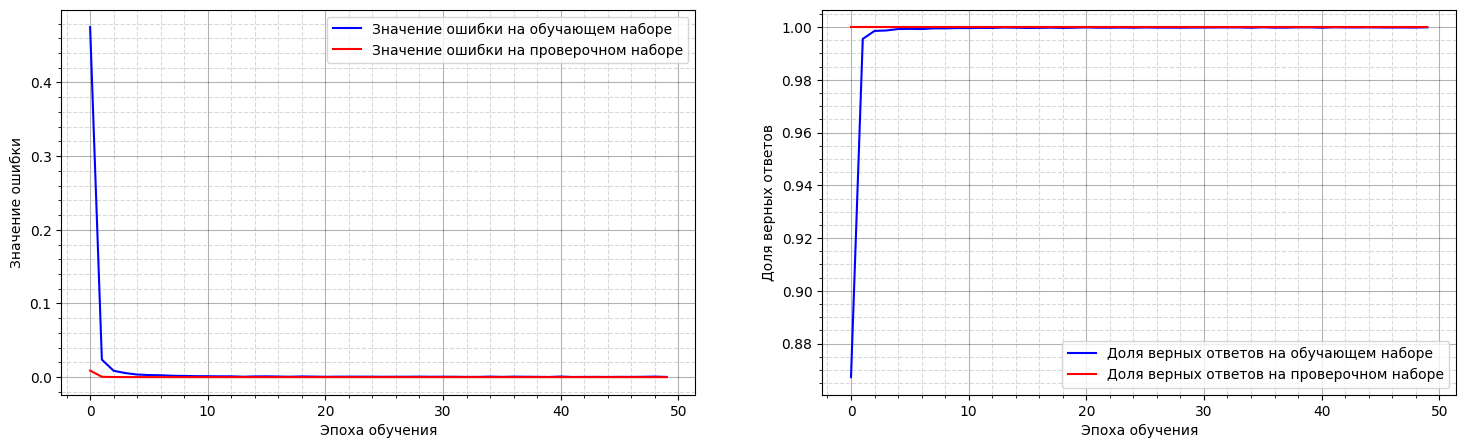

In [104]:
# Отобразим результаты на графике
printNNChart(history1)

# Оценка результатов

In [105]:
# Оценим результат работы нашей сети.
# Применим метод .evaluate() к нашей модели, в качестве параметров
# передадим ему тестовые выборки и согласие на отображение хода вычисления.

scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

922/922 [==============================] - 1s 937us/step - loss: 2.1343e-09 - accuracy: 1.0000
Процент верных ответов на тестовых данных: 100.0 %


In [106]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
val_acc1 = history1.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
# print(f'Эпохи: {EPOCHS}')
for i in range(EPOCHS):
  # print(f'  {i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc1[i] > val_acc_max:
    val_acc_max = val_acc1[i]
    i_max = i

print(f'Нейронная сеть под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc1[i]*100., 3)}%')

Нейронная сеть под номером: 0 из 50 эпох
  достигла точности: 100.0%


# Оценка предсказаний по тестовой выборке

## Оценка по все тестовой выборке

In [107]:
pred1 = model1.predict(x_test)

# У нас 16-классов Заключения:
# Подсчитаем по каждому верное и неверное предсказания
arr_true = np.zeros(len(conclusion_lst), dtype=int)
arr_false = np.zeros(len(conclusion_lst), dtype=int)

for i in range(y_test.shape[0]):
  # Получение индекса самого большого элемента
  # потому что мы имеем дело с one-hot-encoding, поэтому необходимо
  # определить элемент в массиве с максимальным значением,
  # индекс этого элемента и будет говорить о верном элементе
  #~индекс тестового элемента
  y_inx_max = np.argmax(y_test[i,:])
  #~индекс предсказанного элемента
  pred_inx_max = np.argmax(pred1[i,:])
  #~~~
  if y_inx_max == pred_inx_max:
    # верное предсказание
    arr_true[y_inx_max] += 1
  else:
    # неверное предсказания
    arr_false[y_inx_max] += 1

# Результаты предсказаний по тестовой выборке
print(f'Результаты предсказаний по тестовой выборке ({y_test.shape[0]} - записей)')

print('Заключение:')
for i in range(len(conclusion_lst)):
  print(f'  {i}: код: {conclusion_lst[i]}')
  print(f'        верное: {arr_true[i]}')
  print(f'        неверное: {arr_false[i]}')

922/922 [==============================] - 1s 860us/step
Результаты предсказаний по тестовой выборке (29491 - записей)
Заключение:
  0: код: 111116
        верное: 14748
        неверное: 0
  1: код: 111125
        верное: 1640
        неверное: 0
  2: код: 111127
        верное: 1640
        неверное: 0
  3: код: 111132
        верное: 409
        неверное: 0
  4: код: 111155
        верное: 2046
        неверное: 0
  5: код: 111175
        верное: 1230
        неверное: 0
  6: код: 112255
        верное: 1637
        неверное: 0
  7: код: 112311
        верное: 409
        неверное: 0
  8: код: 112314
        верное: 409
        неверное: 0
  9: код: 112327
        верное: 818
        неверное: 0
  10: код: 112411
        верное: 409
        неверное: 0
  11: код: 112447
        верное: 818
        неверное: 0
  12: код: 112555
        верное: 820
        неверное: 0
  13: код: 112567
        верное: 818
        неверное: 0
  14: код: 223311
        верное: 820
        неверное: 0
  

## Оценка предсказаний по 104-й строке тестовой выборки

In [108]:
x_row2 = x_test[104].astype(int).tolist()
print(f'x_row2: length: {len(x_row2)}: {x_row2}')

x_row2: length: 35: [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [109]:
def getXLstVector(inxStage,inxHistology,inxECOG,inxAge,inxGender,inxMolecularStatus,
                  inxPD_L1Status,inxSmokingStatus,inxContraindicationsRT,inxPatientPreference):
  '''
  Числовое кодирование X-вектора

  Args:
    inxStage...inxPatientPreference - числовые индексы из списка возможных

  Returns:
    массив числовых кодов
  '''
  #~~~~~~~~~~~~~~~~~~~~~~~~
  # print(f"#~1. 'Стадия': `{inxStage}`")
  # print(f"#~2. 'Гистология': `{inxHistology}`")
  # print(f"#~3. 'ECOG': `{inxECOG}`")
  # print(f"#~4. 'Возраст': `{inxAge}`")
  # print(f"#~5. 'Пол': `{inxGender}`")
  # print(f"#~6. 'Молекулярный статус (только для неплоскоклеточного рака)': `{inxMolecularStatus}`")
  # print(f"#~7. 'PD-L1 статус': `{inxPD_L1Status}`")
  # print(f"#~8. 'Статус курения': `{inxSmokingStatus}`")
  # print(f"#~9. 'Относительные противопоказания к ЛТ': `{inxContraindicationsRT}`")
  # print(f"#~10. 'Предпочтение пациента по ответу на терапию': `{inxPatientPreference}`")
  #~~~~~~~~~~~~~~~~~~~~~~~~
  retVal = []
  #~~~1. 'Стадия'
  retVal.append(inxStage)
  #~~~2. 'Гистология': one-hot-encoding
  ohe_arr2 = utils.to_categorical(inxHistology, 3)
  ohe_lst2 = ohe_arr2.astype(int).tolist()
  # print(f'ohe_arr2: {ohe_arr2}')
  # print(f'ohe_lst2: {ohe_lst2}')
  retVal.extend(ohe_lst2)
  #~~~3. 'ECOG'
  ohe_arr3 = utils.to_categorical(inxECOG, 3)
  ohe_lst3 = ohe_arr3.astype(int).tolist()
  retVal.extend(ohe_lst3)
  #~~~4. 'Возраст'
  retVal.append(inxAge)
  #~~~5. 'Пол'
  retVal.append(inxGender)
  #~~~6. 'Молекулярный статус (только для неплоскоклеточного рака)'
  ohe_arr6 = utils.to_categorical(inxMolecularStatus, 16)
  ohe_lst6 = ohe_arr6.astype(int).tolist()
  retVal.extend(ohe_lst6)
  #~~~7. 'PD-L1 статус'
  ohe_arr7 = utils.to_categorical(inxPD_L1Status, 4)
  ohe_lst7 = ohe_arr7.astype(int).tolist()
  retVal.extend(ohe_lst7)
  #~~~8. 'Статус курения'
  ohe_arr8 = utils.to_categorical(inxSmokingStatus, 4)
  ohe_lst8 = ohe_arr8.astype(int).tolist()
  retVal.extend(ohe_lst8)
  #~~~9. 'Относительные противопоказания к ЛТ'
  retVal.append(inxContraindicationsRT)
  #~~~10. 'Предпочтение пациента по ответу на терапию'
  retVal.append(inxPatientPreference)
  #~~~~~~~~~~~~~~~~~~~~~~~~
  del ohe_arr2
  del ohe_lst2
  del ohe_arr3
  del ohe_lst3
  del ohe_arr6
  del ohe_lst6
  del ohe_arr7
  del ohe_lst7
  del ohe_arr8
  del ohe_lst8
  #~~~~~~~~~~~~~~~~~~~~~~~~
  return retVal

In [110]:
#~1. 'Стадия': 0|IIIаI
inxStage = 0
#~2. 'Гистология': 1|неплоскоклеточный
inxHistology = 1
#~3. 'ECOG': 2|3+
inxECOG = 2
#~4. 'Возраст': 0|до 70
inxAge = 0
#~5. 'Пол': 1|женский
inxGender = 1
#~6. 'Молекулярный статус (только для неплоскоклеточного рака)': 1|нет мутаций
inxMolecularStatus = 1
#~7. 'PD-L1 статус': 0|не исследовался
inxPD_L1Status = 0
#~8. 'Статус курения': 0|в настоящее время
inxSmokingStatus = 0
#~9. 'Относительные противопоказания к ЛТ': 0|нет
inxContraindicationsRT = 0
#~10. 'Предпочтение пациента по ответу на терапию': 0|результативность лечения
inxPatientPreference = 0

x_row_lst = getXLstVector(inxStage,inxHistology,inxECOG,inxAge,inxGender,inxMolecularStatus,
                          inxPD_L1Status,inxSmokingStatus,inxContraindicationsRT,inxPatientPreference)

print(f'x_row_lst: length: {len(x_row_lst)}: {x_row_lst}')

x_row_lst: length: 35: [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [111]:
x_row_arr = np.array(x_row_lst, dtype=np.float32).reshape(1, len(x_row_lst))
print(x_row_arr)

[[0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [112]:
pred2 = model1.predict(x_row_arr)

1/1 [==============================] - 0s 16ms/step


In [113]:
print(pred2)
print('pred2:')
print(f'  тип: {type(pred2)}')
print(f'  тип данных: {pred2.dtype}')
print(f'  количество осей: {pred2.ndim}')
print(f'  форма массива: {pred2.shape}')
print(f'  количество значений: {pred2.size}')

[[5.7672930e-34 1.7624672e-16 5.8171301e-15 3.8660317e-18 0.0000000e+00
  1.2518116e-27 1.9223660e-30 5.5019765e-25 6.4643004e-30 5.9473650e-36
  1.6612071e-13 4.3860272e-23 7.1278567e-18 3.5875305e-26 8.9848597e-12
  1.0000000e+00]]
pred2:
  тип: <class 'numpy.ndarray'>
  тип данных: float32
  количество осей: 2
  форма массива: (1, 16)
  количество значений: 16


In [114]:
pred2_inx_max = np.argmax(pred2[0,:])
print(f'pred2_inx_max: {pred2_inx_max}')

pred2_inx_max: 15


In [115]:
def reverse_conclusion(num):
  '''
  Реверсирование кода заключения и перевод чисел в слова

  Args:
    num - числовой код заключения

  Returns:
    список значений
  '''

  retVal = []

  #~~~~~~~~~~~~~~~~~~~~~~~~
  digits = []
  while num > 0:
    digits.append(num % 10)
    num //= 10
  print(f'digits: len: {len(digits)}: {digits}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~~~ 11 - L1 - 'Ответ эксперта (Лактионов)'
  retVal.append(getReverseExpertRecommendationCode(digits[0]))
  #~~~ 12 - L1 - 'Вариант ХТ'
  retVal.append(getReverseChemotherapyVariantCode(digits[1]))
  #~~~ 13 - L1 - 'Альтернативный выбор ХТ (как компонента ХЛТ)'
  retVal.append(getReverseAlternativeChemotherapyVariantCode(digits[2]))
  #~~~ 14 - L1 - 'Поставьте галочку, если уверены на 100%'
  #~~~ 15 - L1 - 'Если 75%'
  #~~~ 16 - L1 - 'Если 50%'
  retVal.append(getReverseConfidence1007550Code(digits[3]))
  #~~~ 17 - L1 - 'Альтернатива, если 50% - обязательно'
  retVal.append(getReverseAlternativeTherapy50Code(digits[4]))
  #~~~ 18 - L1 - 'Комментарий'
  retVal.append(getReverseCommentCode(digits[5]))

  return retVal

In [116]:
conclusion_code = conclusion_lst[pred2_inx_max]
print(f'conclusion_code: {conclusion_code}')

rev_conclusion_lst = reverse_conclusion(conclusion_code)
print(f'rev_conclusion_lst: len: {len(rev_conclusion_lst)}: {rev_conclusion_lst}')

conclusion_code: 223443
digits: len: 6: [3, 4, 4, 3, 2, 2]
rev_conclusion_lst: len: 6: ['ПХТ', 'Пеметрексед+Цисплатин', 'Пеметрексед', 'уверенность 50%', 'вариант лечения IV стадии', 'большая вероятность инкурабельности больного']


# Сохранение модели

In [117]:
# Определение пути к папке на Google Drive
# model_path = '/content/drive/MyDrive/Stazhirovka2'
# Определение пути к файлу модели
model_path = 'c:/LungCancer_AIConsultant/data_in/model2100/model21000.h5'
print(f"model_path: '{model_path}'")

model_path: 'c:/LungCancer_AIConsultant/data_in/model2100/model21000.h5'


In [118]:
# Сохранение модели с весами в файл
model1.save(model_path)